In [2]:
# Imports

import db_functions
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import re
import warnings

import extented_pandas

from matplotlib import pyplot as plt
from enum import Enum

pd.options.display.max_columns = 999

In [3]:
## Initial declarations

# Open DB connections
db_connection, db_cursor = db_functions.connect_to_database_mysql_connector()

# Decorator for the pipeline
pipeline_functions_dict = {}

def make_pipeline(func):
    pipeline_functions_dict[func.__name__] = func
    return func

# Enumerator for working with the dataframe columns
class Cols(Enum):
	Title = 'title'
	Type = 'tipo'
	Price = 'price'
	Floor = 'floor'
	Condominium = 'condominium_fee'
	Address = 'adress'
	District = 'bairro'
	Price_to_condominium_ratio = 'price_to_condominium_ratio'
	Area = 'area'
	Bedrooms = 'bedrooms'
	Garages = 'garage_spaces'
	Bathrooms = 'bathrooms'
	Test = 'test'
        
# Retrieves districts form Wikipedia
def get_districts() -> list:
	url = 'https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Balne%C3%A1rio_Cambori%C3%BA'

	df_districts = pd.read_html(url, header=0)[0]
	districts = df_districts['Bairro'].str.replace('(Das|Da|Dos)', '', regex=True).str.strip()

	# Removing header and footer
	districts = districts[(districts != 'TOTAL') & (districts != 'Bairro')]

	districts = districts.to_numpy()
	districts = np.insert(districts, 0, 'Barra Sul')
	return districts

print(f'Districts: {", ".join(get_districts())}')

Districts: Barra Sul, Ariribá, Centro, Barra, Nações, Estados, Municípios, Pioneiros, Jardim Iate Clube, Nova Esperança, Praia dos Amores, Região das Praias, São Judas Tadeu, Várzea do Ranchinho, Vila Real


In [4]:
# Retrieve data from 1st February 2023
useful_columns = ['id', 'title', 'adress', 'condominium_fee', 'price', 'taxes', 'area', 'bedrooms', 'garage_spaces', 'bathrooms', 'floor']
string_useful_columns = '`, `'.join(useful_columns)

df_train = pd.read_sql(f'SELECT `{string_useful_columns}` FROM `dados-imoveis` WHERE `scrapped_date` = "2023-02-01"', con=db_connection).set_index('id')
df_train[Cols.Test.value] = False

print(df_train.shape)
df_train

(9616, 11)


C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\4124124750.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_train = pd.read_sql(f'SELECT `{string_useful_columns}` FROM `dados-imoveis` WHERE `scrapped_date` = "2023-02-01"', con=db_connection).set_index('id')


,title,adress,condominium_fee,price,taxes,area,bedrooms,garage_spaces,bathrooms,floor,test
id,,,,,,,,,,,
1,"Cobertura com 3 Quartos à venda, 240m² - Centro","Rua 901 - Centro, Balneário Camboriú - SC",NaN,4200000,NaN,240.0,3.0,2.0,1.0,NaN,False
2,"Apartamento com 4 Quartos à venda, 167m² - Centro","Rua 2950 - Centro, Balneário Camboriú - SC",NaN,3418419,NaN,167.0,4.0,3.0,2.0,NaN,False
3,"Apartamento com 4 Quartos à venda, 149m² - Centro","Rua 3140 - Centro, Balneário Camboriú - SC",NaN,2400000,NaN,149.0,4.0,2.0,1.0,NaN,False
4,"Apartamento com 4 Quartos à venda, 129m² - Centro","Avenida do Estado Dalmo Vieira - Centro, Balne...",NaN,2751000,NaN,129.0,4.0,2.0,2.0,NaN,False
5,"Apartamento com 3 Quartos à venda, 118m² - Centro","Rua 1901 - Centro, Balneário Camboriú - SC",NaN,2398000,NaN,118.0,3.0,2.0,1.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
9632,"Apartamento com 2 Quartos à venda, 90m² - Centro","Rua 904 - Centro, Balneário Camboriú - SC",400.0,1000000,NaN,90.0,2.0,1.0,2.0,NaN,False
9633,"Apartamento com 3 Quartos à venda, 76m² - Centro","Avenida do Estado Dalmo Vieira - Centro, Balne...",NaN,990000,NaN,76.0,3.0,1.0,2.0,NaN,False
9634,"Apartamento com 4 Quartos à venda, 215m² - Centro","Rua 4100 - Centro, Balneário Camboriú - SC",1138.0,1200000,4211.0,215.0,4.0,2.0,3.0,NaN,False


In [5]:
# Retrieve data after 1st February 2023 for testing

df_test = pd.read_sql(f'SELECT `{string_useful_columns}` FROM `dados-imoveis` WHERE `scrapped_date` > "2023-02-01"', con=db_connection).set_index('id')
df_test[Cols.Test.value] = True
y_test = df_test[Cols.Price.value]
df_test = df_test.drop(columns=Cols.Price.value)

print(df_test.shape)
df_test

(5965, 10)


C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\1289593614.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_test = pd.read_sql(f'SELECT `{string_useful_columns}` FROM `dados-imoveis` WHERE `scrapped_date` > "2023-02-01"', con=db_connection).set_index('id')


,title,adress,condominium_fee,taxes,area,bedrooms,garage_spaces,bathrooms,floor,test
id,,,,,,,,,,
9657,"Apartamento com 3 Quartos à venda, 133m² - Pra...",Avenida do Estado Dalmo Vieira - Praia dos Amo...,NaN,NaN,133.0,3.0,2.0,2.0,NaN,True
9658,"Apartamento com 4 Quartos à venda, 167m² - Centro","Avenida Brasil - Centro, Balneário Camboriú - SC",NaN,NaN,167.0,4.0,2.0,1.0,NaN,True
9659,"Cobertura com 6 Quartos à venda, 471m² - Centro","Rua 2300 - Centro, Balneário Camboriú - SC",NaN,NaN,471.0,6.0,3.0,3.0,NaN,True
9660,"Apartamento com 2 Quartos à venda, 118m² - Pra...",Avenida do Estado Dalmo Vieira - Praia dos Amo...,NaN,NaN,118.0,2.0,1.0,1.0,NaN,True
9661,"Apartamento com 3 Quartos à venda, 112m² - Centro","Rua 2950, 300 - Centro, Balneário Camboriú - SC",598.0,1486.0,112.0,3.0,2.0,3.0,11.0,True
...,...,...,...,...,...,...,...,...,...,...
15715,"Prédio Inteiro com 28 Quartos à venda, 641m² -...","Rua 3050, 120 - Centro, Balneário Camboriú - SC",2400.0,9000.0,641.0,28.0,NaN,29.0,3.0,True
15716,"Apartamento com 3 Quartos à venda, 110m² - Centro","Rua 951 - Centro, Balneário Camboriú - SC",640.0,1.0,110.0,3.0,2.0,2.0,4.0,True
15717,"Apartamento com 3 Quartos à venda, 254m² - Centro","Centro, Balneário Camboriú - SC",1442.0,7956.0,254.0,3.0,4.0,4.0,NaN,True


In [6]:
# Joining dataframes

df = pd.concat([df_train, df_test])
print(len(df_train) + len(df_test))
print(df.shape)

df.head()

15581
(15581, 11)


,title,adress,condominium_fee,price,taxes,area,bedrooms,garage_spaces,bathrooms,floor,test
id,,,,,,,,,,,
1,"Cobertura com 3 Quartos à venda, 240m² - Centro","Rua 901 - Centro, Balneário Camboriú - SC",NaN,4200000.0,NaN,240.0,3.0,2.0,1.0,NaN,False
2,"Apartamento com 4 Quartos à venda, 167m² - Centro","Rua 2950 - Centro, Balneário Camboriú - SC",NaN,3418419.0,NaN,167.0,4.0,3.0,2.0,NaN,False
3,"Apartamento com 4 Quartos à venda, 149m² - Centro","Rua 3140 - Centro, Balneário Camboriú - SC",NaN,2400000.0,NaN,149.0,4.0,2.0,1.0,NaN,False
4,"Apartamento com 4 Quartos à venda, 129m² - Centro","Avenida do Estado Dalmo Vieira - Centro, Balne...",NaN,2751000.0,NaN,129.0,4.0,2.0,2.0,NaN,False
5,"Apartamento com 3 Quartos à venda, 118m² - Centro","Rua 1901 - Centro, Balneário Camboriú - SC",NaN,2398000.0,NaN,118.0,3.0,2.0,1.0,NaN,False


In [7]:
# Retrieving all amenities data

sql_query_amenities = 'SELECT * FROM `imoveis-balneario-camboriu`.amenities WHERE house_id in (SELECT id FROM `dados-imoveis`);'

df_amenities = pd.read_sql(sql_query_amenities, con=db_connection) \
    .drop(columns='id') \
    .set_index('house_id') \
    .fillna(0)

print('Shape', df_amenities.shape)

df_amenities.head()

C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\1597739387.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_amenities = pd.read_sql(sql_query_amenities, con=db_connection) \


Shape (15402, 167)


,academia,aceita_animais,acesso_para_deficientes,ambientes_integrados,andar_inteiro,aquecimento,aquário,ar-condicionado,arenoso,argiloso,armário_embutido,armário_embutido_no_quarto,armário_na_cozinha,armário_no_banheiro,arvorismo,banheira,banheiro_de_serviço,bar,bar_na_piscina,bicicletário,box_blindex,brinquedoteca,cabeamento_estruturado,campo_de_futebol,churrasqueira,churrasqueira_na_varanda,chuveiro_a_gás,cinema,circuito_de_segurança,closet,condomínio_fechado,conexão_à_internet,copa,coworking,cozinha,cozinha_americana,cozinha_gourmet,cozinha_grande,câmera_de_segurança,dependência_de_empregados,depósito,desnível_para_frente_(rua),desnível_para_trás_(fundo),despensa,edícula,elevador,energia_elétrica,entrada_de_serviço,entrada_lateral,escritório,espaço_gourmet,espaço_pet,espaço_teen,espaço_verde_/_parque,espaço_zen,espelhos_d'água,estacionamento,estacionamento_para_visitantes,fogão,forno_de_pizza,freezer,frente_para_o_leste,frente_para_o_norte,frente_para_o_oeste,frente_para_o_sul,garagem,geminada,gerador_elétrico,gesso_-_sanca_-_teto_rebaixado,gramado,guarita,gás_encanado,hall_de_entrada,heliponto,hidromassagem,horta,imóvel_de_esquina,interfone,isolamento_acústico,isolamento_térmico,janela_de_alumínio,janela_grande,jardim,lago,laje,lareira,lavabo,lavanderia,mais_de_um_andar,marina,meio_andar,mezanino,mobiliado,móvel_planejado,perto_de_escolas,perto_de_hospitais,perto_de_shopping,perto_de_transporte_público,perto_de_vias_de_acesso,piscina,piscina_aquecida,piscina_coberta,piscina_infantil,piscina_para_adulto,piscina_privativa,piso_frio,piso_laminado,piso_vinílico,pista_de_cooper,plano,playground,pomar,porcelanato,portaria_24h,portão_eletrônico,possui_divisória,praça,próximo_a_shopping,pé_direito_alto,quadra_de_squash,quadra_de_tênis,quadra_poliesportiva,quarto_de_serviço,quintal,recepção,rede_de_água_e_esgoto,ronda/vigilância,rua_asfaltada,sala_de_jantar,sala_de_massagem,sala_grande,salão_de_festas,salão_de_jogos,sauna,segurança_24h,serviços_pay_per_use,serviços_públicos_essenciais,sistema_de_alarme,solarium,spa,terra,tv_a_cabo,varanda,varanda_fechada_com_vidro,varanda_gourmet,vigia,vista_exterior,vista_panorâmica,vista_para_a_montanha,vista_para_o_mar,área_de_lazer,área_de_serviço,árvore_frutífera,ofurô,deck,cobertura_coletiva,poço_artesiano,pista_de_skate,escada,sala_de_almoço,canil,orquidário,ventilação_natural,piso_de_madeira,muro_e_grade,vista_para_lago,sala_de_reunião
house_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0

In [8]:
# Checking which type to use

df_amenities.astype('int8').info()
print('')
df_amenities.astype('bool').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15402 entries, 1 to 15719
Columns: 167 entries, academia to sala_de_reunião
dtypes: int8(167)
memory usage: 2.6 MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15402 entries, 1 to 15719
Columns: 167 entries, academia to sala_de_reunião
dtypes: bool(167)
memory usage: 2.6 MB


In [9]:
# Converting df Amenities datatype

@make_pipeline
def correct_amenities_datatype(df_in: pd.DataFrame) -> pd.DataFrame:
	return df_in.astype('int8')

df_amenities = pipeline_functions_dict['correct_amenities_datatype'](df_amenities)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15581 entries, 1 to 15719
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            15581 non-null  object 
 1   adress           15581 non-null  object 
 2   condominium_fee  6858 non-null   float64
 3   price            9616 non-null   float64
 4   taxes            5795 non-null   float64
 5   area             15560 non-null  float64
 6   bedrooms         14676 non-null  float64
 7   garage_spaces    14486 non-null  float64
 8   bathrooms        15079 non-null  float64
 9   floor            1790 non-null   float64
 10  test             15581 non-null  bool   
dtypes: bool(1), float64(8), object(2)
memory usage: 1.3+ MB


# 1. Pre-cleaning

## 1.1 Dropping duplicates

In [11]:
@make_pipeline
def df_drop_duplicates(df_in: pd.DataFrame) -> pd.DataFrame:
	print('Number of duplicates dropped:', df_in[df_in.duplicated()].shape[0])
	return df_in.drop_duplicates()

df = pipeline_functions_dict['df_drop_duplicates'](df)

Number of duplicates dropped: 783


## 1.2 Adding Type Column

In [12]:
# Including the type column
@make_pipeline
def insert_type_column(df_in: pd.DataFrame) -> pd.DataFrame:
	df_in.loc[:, Cols.Type.value] = df_in[Cols.Title.value].str.split('( à venda| para venda )', expand=True, regex=True)[0]
	df_in.loc[:, Cols.Type.value] = df_in[Cols.Type.value].str.split(' com ', expand=True)[0]
	return df_in

df = pipeline_functions_dict['insert_type_column'](df)

df[Cols.Type.value].value_counts().head(20)

Apartamento                       11946
Casa                                954
Cobertura                           630
Conjunto Comercial / Sala           329
Terreno / Lote / Condomínio         308
Casa de Condomínio                  232
Loja / Salão / Ponto Comercial       98
Casa Comercial                       47
com 1 Quarto                         42
Prédio Inteiro                       26
Kitnet                               14
Flat                                 12
Terreno / Lote Comercial             11
Casa de Vila                          9
Galpão / Depósito / Armazém           9
Fazenda / Sítio / Chácara             7
à venda, 97m² - Centro                6
à venda, 2378m² - Nacoes              5
à venda, 37m² - Centro                5
à venda, 56m² - Centro                4
Name: tipo, dtype: int64

In [13]:
# Keeping only types of interest
@make_pipeline
def keep_only_certain_types(df_in: pd.DataFrame) -> pd.DataFrame:
	house_types = ['Apartamento', 'Casa', 'Cobertura', 'Casa de Condomínio']
	mask_house_types = df_in[Cols.Type.value].str.contains(f'(?:{"$|".join(house_types)})', regex=True)
	
	print('Percentage of relevant entriess by type: ', "%.1f" % ((len(df[mask_house_types]) / len(df))*100 )+ '%')

	return df_in[mask_house_types]

df = pipeline_functions_dict['keep_only_certain_types'](df)

df[Cols.Type.value].value_counts()

Percentage of relevant entriess by type:  93.0%


Apartamento           11946
Casa                    954
Cobertura               630
Casa de Condomínio      232
Name: tipo, dtype: int64

## 1.3 Adding district column

For this we'll retrieve from Wikipedia the district names, remove the words 'das' and 'dos', which are often ommited from the adressess, add Barra Sul which is an commom informal neighbourhood found in exploration, then search for these keywords in the adresses.

In [14]:
# Setting distric column and checking values
@make_pipeline
def set_district_columm(df_in: pd.DataFrame) -> pd.DataFrame:
	districts = get_districts()
	df_in[Cols.District.value] = df_in[Cols.Address.value].str.extract('({})'.format('|'.join(districts)), flags=re.IGNORECASE)
	
	sum_empty = df_in[Cols.District.value].isna().sum().sum()
	print(f'Empty values in the district column that will be dropped: {sum_empty} - % of total: {sum_empty / len(df_in):.2%}')

	# Dropna
	df_in = df_in[~df_in[Cols.District.value].isna()]

	return df_in

df = pipeline_functions_dict['set_district_columm'](df)

df[Cols.District.value].value_counts()

Empty values in the district column that will be dropped: 983 - % of total: 7.14%


Centro               10050
Pioneiros             1042
Barra Sul              498
Barra                  360
Ariribá                351
Praia dos Amores       183
Vila Real              108
Estados                101
São Judas Tadeu         47
Nações                  25
Jardim Iate Clube       12
Região das Praias        1
Municípios               1
Name: bairro, dtype: int64

### 1.2.1 Inference

1. Most entries are from just one district - Centro
2. Some Districts have way too few entries, as to not give a bias to these districts we'll input anything below 100 as others
3. Since there aren't many NA values we'll drop them instead of inputting a value

### 1.2.2 Removing small districts and dropping NA districts

In [15]:
# Removing small districts
@make_pipeline
def remove_small_districts(df_in: pd.DataFrame) -> pd.DataFrame:
	distric_count = df_in[Cols.District.value].value_counts()
	small_districts = {i_district:'other' for i_district in distric_count[distric_count < 100].index}

	df_in[Cols.District.value] = df_in[Cols.District.value].replace(small_districts)
		
	return df_in

df = pipeline_functions_dict['remove_small_districts'](df)

print(df.shape)
df.head()

(12779, 13)


,title,adress,condominium_fee,price,taxes,area,bedrooms,garage_spaces,bathrooms,floor,test,tipo,bairro
id,,,,,,,,,,,,,
1,"Cobertura com 3 Quartos à venda, 240m² - Centro","Rua 901 - Centro, Balneário Camboriú - SC",NaN,4200000.0,NaN,240.0,3.0,2.0,1.0,NaN,False,Cobertura,Centro
2,"Apartamento com 4 Quartos à venda, 167m² - Centro","Rua 2950 - Centro, Balneário Camboriú - SC",NaN,3418419.0,NaN,167.0,4.0,3.0,2.0,NaN,False,Apartamento,Centro
3,"Apartamento com 4 Quartos à venda, 149m² - Centro","Rua 3140 - Centro, Balneário Camboriú - SC",NaN,2400000.0,NaN,149.0,4.0,2.0,1.0,NaN,False,Apartamento,Centro
4,"Apartamento com 4 Quartos à venda, 129m² - Centro","Avenida do Estado Dalmo Vieira - Centro, Balne...",NaN,2751000.0,NaN,129.0,4.0,2.0,2.0,NaN,False,Apartamento,Centro
5,"Apartamento com 3 Quartos à venda, 118m² - Centro","Rua 1901 - Centro, Balneário Camboriú - SC",NaN,2398000.0,NaN,118.0,3.0,2.0,1.0,NaN,False,Apartamento,Centro


## 1.4 Summary

In [16]:
extented_pandas.infoOut(df, details=True)

Max/Min non-null: (12779, 1545) 

         # Dtypes
float64         8
object          4
bool            1 



,Column,# Non-Null,Dtype,% Non-Null
1,title,12779,object,100%
2,adress,12779,object,100%
3,condominium_fee,6034,float64,47%
4,price,8030,float64,63%
5,taxes,5029,float64,39%
6,area,12779,float64,100%
7,bedrooms,12779,float64,100%
8,garage_spaces,12379,float64,97%
9,bathrooms,12779,float64,100%
10,floor,1545,float64,12%


### 1.3.1 Inference

1. Floor and taxes have way too much null values, we'll drop these columns as they are not reliable for prediction

In [17]:
# Removes floor and taxes
@make_pipeline
def drop_floor_and_taxes(df_in: pd.DataFrame) -> pd.DataFrame:
	return df_in.drop(['floor', 'taxes'], axis=1)

df = pipeline_functions_dict['drop_floor_and_taxes'](df)
df.head()

,title,adress,condominium_fee,price,area,bedrooms,garage_spaces,bathrooms,test,tipo,bairro
id,,,,,,,,,,,
1,"Cobertura com 3 Quartos à venda, 240m² - Centro","Rua 901 - Centro, Balneário Camboriú - SC",NaN,4200000.0,240.0,3.0,2.0,1.0,False,Cobertura,Centro
2,"Apartamento com 4 Quartos à venda, 167m² - Centro","Rua 2950 - Centro, Balneário Camboriú - SC",NaN,3418419.0,167.0,4.0,3.0,2.0,False,Apartamento,Centro
3,"Apartamento com 4 Quartos à venda, 149m² - Centro","Rua 3140 - Centro, Balneário Camboriú - SC",NaN,2400000.0,149.0,4.0,2.0,1.0,False,Apartamento,Centro
4,"Apartamento com 4 Quartos à venda, 129m² - Centro","Avenida do Estado Dalmo Vieira - Centro, Balne...",NaN,2751000.0,129.0,4.0,2.0,2.0,False,Apartamento,Centro
5,"Apartamento com 3 Quartos à venda, 118m² - Centro","Rua 1901 - Centro, Balneário Camboriú - SC",NaN,2398000.0,118.0,3.0,2.0,1.0,False,Apartamento,Centro


# 2. Data exploration

## 2.1 Numerical Columns

### 2.1.1 Prices

C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\3150795091.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\3150795091.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\3150795091.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\3150795091.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axbig.set_yticklabels(ylabels)


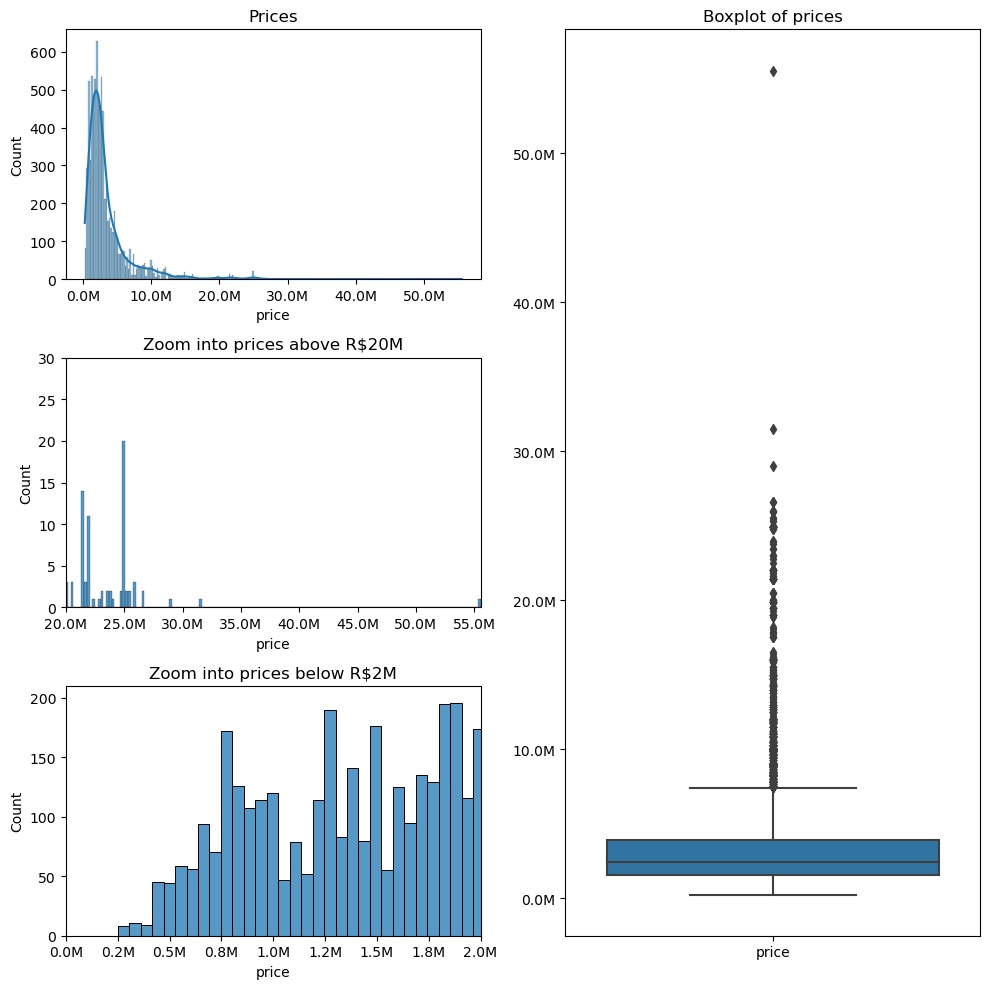

In [18]:
# Plots to understand the distribution and outliers

def set_xticks_to_millions(ax: plt.Axes):
	xlabels = ['{:,.1f}'.format(x) + 'M' for x in ax.get_xticks()/1000000]
	ax.set_xticklabels(xlabels)

fig, axs = plt.subplots(3, 2, figsize=(10,10), sharey=False)
axs = axs.reshape(1, -1)[0]

# All prices
ax = axs[0]
sns.histplot(data=df[Cols.Price.value], ax=ax, kde=True).set(title='Prices')
set_xticks_to_millions(ax)

# Above 20M
ax = axs[2]

ax.set_xlim(left=2e7, right=df[Cols.Price.value].max())
ax.set_ylim(top=30)
sns.histplot(data=df[Cols.Price.value], ax=ax).set(title='Zoom into prices above R$20M')
set_xticks_to_millions(ax)

# Below 3M
ax = axs[4]

ax.set_xlim(right=2e6)
sns.histplot(data=df[Cols.Price.value], ax=ax, bins=1000).set(title='Zoom into prices below R$2M')
set_xticks_to_millions(ax)

# Boxplot with all prices
# remove the underlying axes

for i in [1,3,5]:
	axs[i].remove()

gs = axs[1].get_gridspec()
axbig = fig.add_subplot(gs[0:, 1])
sns.boxplot(data=df[Cols.Price.value].to_frame(), ax=axbig).set(title='Boxplot of prices')

ylabels = ['{:,.1f}'.format(x) + 'M' for x in axbig.get_yticks()/1000000]
axbig.set_yticklabels(ylabels)

fig.tight_layout()

# Note: UserWarning is a bug from Matplotlib and can be ignored

In [19]:
print('Cheapest entries')

df.sort_values(by=Cols.Price.value).head(5)

Cheapest entries


,title,adress,condominium_fee,price,area,bedrooms,garage_spaces,bathrooms,test,tipo,bairro
id,,,,,,,,,,,
3928,"Casa com 2 Quartos à venda, 61m² - Barra","Barra, Balneário Camboriú - SC",NaN,250000.0,61.0,2.0,1.0,1.0,False,Casa,Barra
3738,"Apartamento com 2 Quartos à venda, 50m² - Barra","Barra, Balneário Camboriú - SC",NaN,260000.0,50.0,2.0,1.0,1.0,False,Apartamento,Barra
4710,"Apartamento com 2 Quartos à venda, 45m² - São ...","Rua Sargento Mário Manoel Rodrigues, 310 - São...",NaN,280000.0,45.0,2.0,1.0,1.0,False,Apartamento,other
646,"Apartamento com 2 Quartos à venda, 46m² - São ...","Rua Amara Pereira Corrêa, 100 - São Judas Tade...",NaN,294290.0,46.0,2.0,1.0,1.0,False,Apartamento,other
4334,"Casa com 2 Quartos à venda, 150m² - Barra","Rua Vereador Eduardo Rodrigues de Melo, 42 - B...",NaN,297000.0,150.0,2.0,1.0,1.0,False,Casa,Barra


In [20]:
print('Most expensive entries')

df.sort_values(by=Cols.Price.value).tail(5)

Most expensive entries


,title,adress,condominium_fee,price,area,bedrooms,garage_spaces,bathrooms,test,tipo,bairro
id,,,,,,,,,,,
15714,"Apartamento com 1 Quarto à venda, 52m² - Centro","Avenida Central, 414 - Centro, Balneário Cambo...",500.0,NaN,52.0,1.0,1.0,1.0,True,Apartamento,Centro
15716,"Apartamento com 3 Quartos à venda, 110m² - Centro","Rua 951 - Centro, Balneário Camboriú - SC",640.0,NaN,110.0,3.0,2.0,2.0,True,Apartamento,Centro
15717,"Apartamento com 3 Quartos à venda, 254m² - Centro","Centro, Balneário Camboriú - SC",1442.0,NaN,254.0,3.0,4.0,4.0,True,Apartamento,Centro
15718,"Apartamento com 3 Quartos à venda, 128m² - Fre...","Rua 2400, 82 - Frente Mar Centro, Balneário Ca...",1200.0,NaN,128.0,3.0,2.0,4.0,True,Apartamento,Centro
15719,"Apartamento com 3 Quartos à venda, 157m² - Centro","Rua 1922, 86 - Centro, Balneário Camboriú - SC",600.0,NaN,157.0,3.0,1.0,2.0,True,Apartamento,Centro


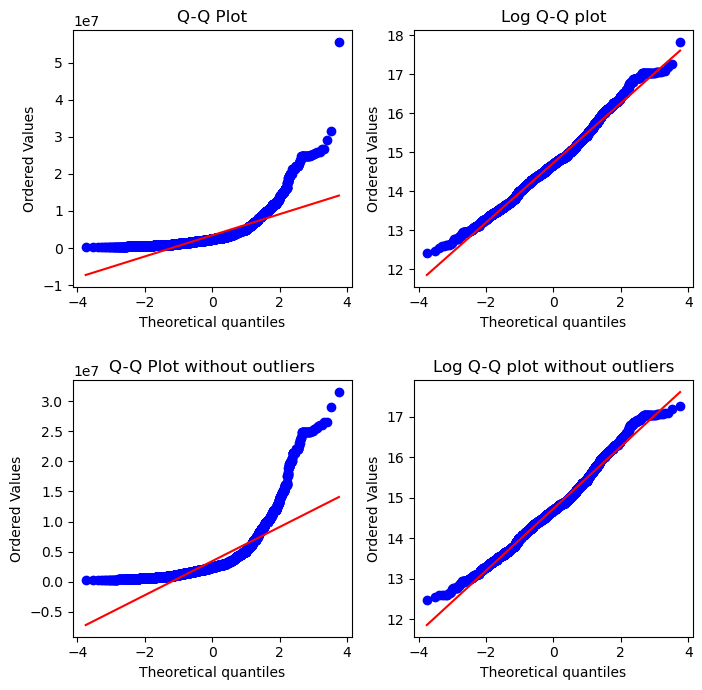

In [21]:
# Probability plots

fig, axs = plt.subplots(2, 2, figsize=(7,7), sharey=False)
axs = axs.reshape(1, -1)[0]

ax = axs[0]

stats.probplot(df[Cols.Price.value].dropna(), plot=ax)
ax.set_title('Q-Q Plot')

ax = axs[1]

stats.probplot(np.log1p(df[Cols.Price.value].dropna().sort_values()).iloc[:], plot=ax)
ax.set_title('Log Q-Q plot');

# Probability plots without outliers
ax = axs[2]

stats.probplot(df[Cols.Price.value].dropna().sort_values().iloc[1:-1], plot=ax)
ax.set_title('Q-Q Plot without outliers')

ax = axs[3]

stats.probplot(np.log1p(df[Cols.Price.value].dropna().sort_values()).iloc[1:-1], plot=ax)
ax.set_title('Log Q-Q plot without outliers');

fig.tight_layout()

In [22]:
format_mapping = {Cols.Price.value: "R$ {:,.0f}"}
pd.DataFrame(df[Cols.Price.value].describe()).style.format(format_mapping)

,price
count,"R$ 8,030"
mean,"R$ 3,451,377"
std,"R$ 3,486,889"
min,"R$ 250,000"
25%,"R$ 1,550,000"
50%,"R$ 2,400,000"
75%,"R$ 3,900,000"
max,"R$ 55,540,000"


#### 2.1.1.1 Inference

1. As expected, the graph is right skewed
2. The box plot and the probability plots show that there are a few outliers, the leftmost outlier is to be considered a typo (the location and price are not realistically feasible) and therefore will be removed while the rightmost is to be maintained
3. The log of the prices are fairly normally distributed and will be used like this for a better model performance
4. The average is 3.4M, while the median lies below that value at 2.4M, as is expected with right skewed data

#### 2.1.1.2 Removing outliers

In [23]:
# Removes prices below 210_000 while keeping the test entries without a price
@make_pipeline
def remove_small_prices(df_in: pd.DataFrame) -> pd.DataFrame:
	df_in = df_in[(df[Cols.Price.value] > 210_000) | (df[Cols.Test.value] == True)]
	return df_in

df = pipeline_functions_dict['remove_small_prices'](df)
df.sort_values(Cols.Price.value).head()

,title,adress,condominium_fee,price,area,bedrooms,garage_spaces,bathrooms,test,tipo,bairro
id,,,,,,,,,,,
3928,"Casa com 2 Quartos à venda, 61m² - Barra","Barra, Balneário Camboriú - SC",NaN,250000.0,61.0,2.0,1.0,1.0,False,Casa,Barra
3738,"Apartamento com 2 Quartos à venda, 50m² - Barra","Barra, Balneário Camboriú - SC",NaN,260000.0,50.0,2.0,1.0,1.0,False,Apartamento,Barra
4710,"Apartamento com 2 Quartos à venda, 45m² - São ...","Rua Sargento Mário Manoel Rodrigues, 310 - São...",NaN,280000.0,45.0,2.0,1.0,1.0,False,Apartamento,other
646,"Apartamento com 2 Quartos à venda, 46m² - São ...","Rua Amara Pereira Corrêa, 100 - São Judas Tade...",NaN,294290.0,46.0,2.0,1.0,1.0,False,Apartamento,other
4334,"Casa com 2 Quartos à venda, 150m² - Barra","Rua Vereador Eduardo Rodrigues de Melo, 42 - B...",NaN,297000.0,150.0,2.0,1.0,1.0,False,Casa,Barra


In [24]:
(df[Cols.Test.value] == True)

id
1        False
2        False
3        False
4        False
5        False
         ...  
15714     True
15716     True
15717     True
15718     True
15719     True
Name: test, Length: 12779, dtype: bool

### 2.1.2 Condominium fees

In [25]:
condomiun_values = df[~df[Cols.Condominium.value].isna()][Cols.Condominium.value].astype(int).sort_values()
condomiun_values.describe().apply(lambda x: format(x, 'f'))

count        6034.000000
mean         6719.995691
std        189999.949373
min             1.000000
25%           520.000000
50%           800.000000
75%          1200.000000
max      11000000.000000
Name: condominium_fee, dtype: object

The mean is way above the 75% percentile, aswell as the maximum value having an unreal amount, this indicates that there were errors while entering the values.

**Ratio**

As the condominium fee usually scales with the house price we'll use this as a comparison to find out which places had a wrongly inputted value

In [26]:
df_condominium_ratio = pd.DataFrame(df[Cols.Condominium.value] / df[Cols.Price.value]).rename({0: Cols.Price_to_condominium_ratio.value}, axis=1)

df_condominium_ratio.describe().drop('count').applymap(lambda x: format(x, '%'))

,price_to_condominium_ratio
mean,0.239724%
std,3.862850%
min,0.000004%
25%,0.030000%
50%,0.040222%
75%,0.052000%
max,100.000000%


C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\2324951453.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\2324951453.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\2324951453.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


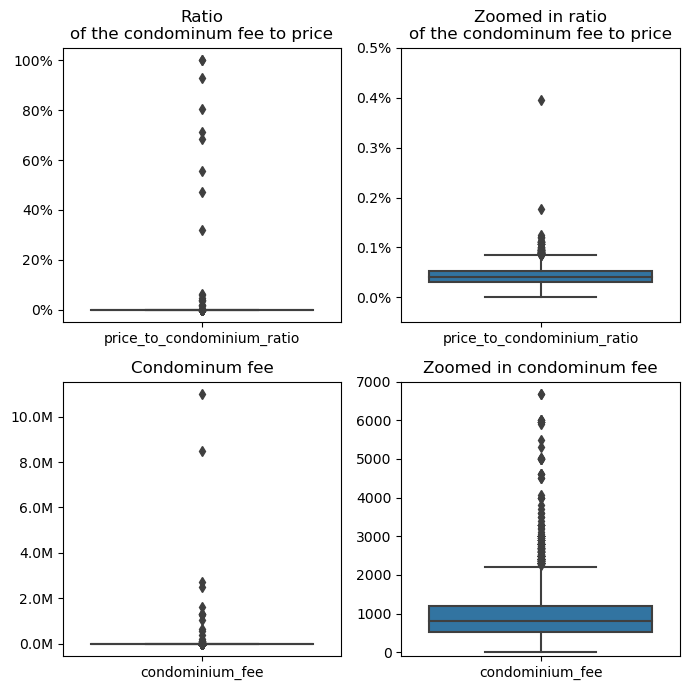

In [27]:
# Boxplots with the condominium fees and their ratios

fig, axs = plt.subplots(2, 2, figsize=(7,7), sharey=False)
axs = axs.reshape(1, -1)[0]

# 0 to 100% plot
ax =axs[0]
sns.boxplot(data=df_condominium_ratio, ax=ax)
ylabels = ['{:.0%}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
ax.set(title='Ratio\nof the condominum fee to price')

# zoomed in plot 0 to 100%
ax = axs[1]

sns.boxplot(data=df_condominium_ratio, ax=ax)
ax.set_ylim(bottom=-0.0005, top=0.005)
ylabels = ['{:.1%}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
ax.set(title='Zoomed in ratio\nof the condominum fee to price')

# Condominium fees
ax = axs[2]

sns.boxplot(data=df[Cols.Condominium.value].to_frame(), ax=ax)
ylabels = ['{:0}M'.format(x/1000000) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
ax.set(title='Condominum fee')

# Zoomed in condominium fees
ax = axs[3]

sns.boxplot(data=df[Cols.Condominium.value].to_frame(), ax=ax)
ax.set(title='Zoomed in condominum fee')
ax.set_ylim(bottom=-100, top=7000)

fig.tight_layout()

In [28]:
# Remove upper bound wrongly inputted condominiums

_, upper_bound_condominium_ratio = extented_pandas.get_lower_and_upper_bounds_for_outliers(df_condominium_ratio[Cols.Price_to_condominium_ratio.value])
print("Number of values above upper bound:", df_condominium_ratio[df_condominium_ratio > upper_bound_condominium_ratio].dropna().count()[0])
print("Number of values below upper bound:", df_condominium_ratio[df_condominium_ratio < upper_bound_condominium_ratio].dropna().count()[0])

df_condominium_ratio = df_condominium_ratio[df_condominium_ratio < upper_bound_condominium_ratio]

Number of values above upper bound: 94
Number of values below upper bound: 3336


In [29]:
# Join DF to further analyse condominium

joint_df = pd.merge(left=df, right=df_condominium_ratio, how='outer', left_index=True, right_index=True)
joint_df = joint_df[joint_df[Cols.Price_to_condominium_ratio.value].isna() == False]

print(joint_df.shape)
joint_df.head(5)

(3336, 12)


,title,adress,condominium_fee,price,area,bedrooms,garage_spaces,bathrooms,test,tipo,bairro,price_to_condominium_ratio
id,,,,,,,,,,,,
91,"Apartamento com 2 Quartos à venda, 77m² - Centro","Rua 2870 - Centro, Balneário Camboriú - SC",350.0,560000.0,77.0,2.0,1.0,1.0,False,Apartamento,Centro,0.000625
94,"Apartamento com 2 Quartos à venda, 75m² - Centro","Centro, Balneário Camboriú - SC",400.0,780000.0,75.0,2.0,1.0,2.0,False,Apartamento,Centro,0.000513
95,"Apartamento com 3 Quartos à venda, 135m² - Centro","Centro, Balneário Camboriú - SC",1100.0,1800000.0,135.0,3.0,2.0,4.0,False,Apartamento,Centro,0.000611
99,"Apartamento com 4 Quartos à venda, 241m² - Centro","Centro, Balneário Camboriú - SC",2000.0,2400000.0,241.0,4.0,3.0,5.0,False,Apartamento,Centro,0.000833
101,"Casa de Condomínio com 5 Quartos à venda, 525m...","Avenida das Arapongas, 650 - Ariribá, Balneári...",1200.0,5500000.0,525.0,5.0,6.0,6.0,False,Casa de Condomínio,Ariribá,0.000218


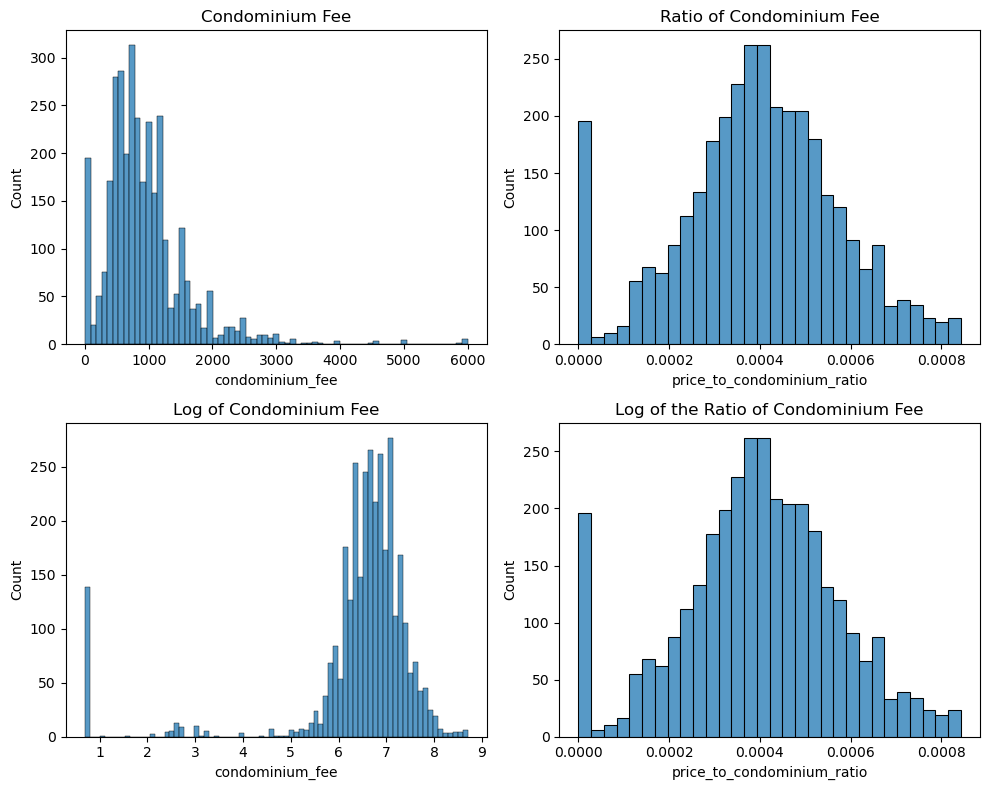

In [30]:
# Histplot of condominium and ratio

fig, axs = plt.subplots(2, 2, figsize=(10,8), sharey=False)
axs = axs.reshape(1, -1)[0]

# Condominium

ax = axs[0]
sns.histplot(data=joint_df[Cols.Condominium.value], ax=ax)
ax.set_title('Condominium Fee')

# Ratio

ax = axs[1]
sns.histplot(data=joint_df[Cols.Price_to_condominium_ratio.value], ax=ax)
ax.set_title('Ratio of Condominium Fee')

# Condominium

ax = axs[2]
sns.histplot(data=np.log1p(joint_df[Cols.Condominium.value]), ax=ax)
ax.set_title('Log of Condominium Fee')

# Ratio

ax = axs[3]
sns.histplot(data=joint_df[Cols.Price_to_condominium_ratio.value], ax=ax)
ax.set_title('Log of the Ratio of Condominium Fee')

fig.tight_layout()

**Lower Bound**

In the logs there are clear outliers on the left side of the graph, there appears to be human input error to all values below 100, as these a not feasiable condominium values, these values will be removed as well.

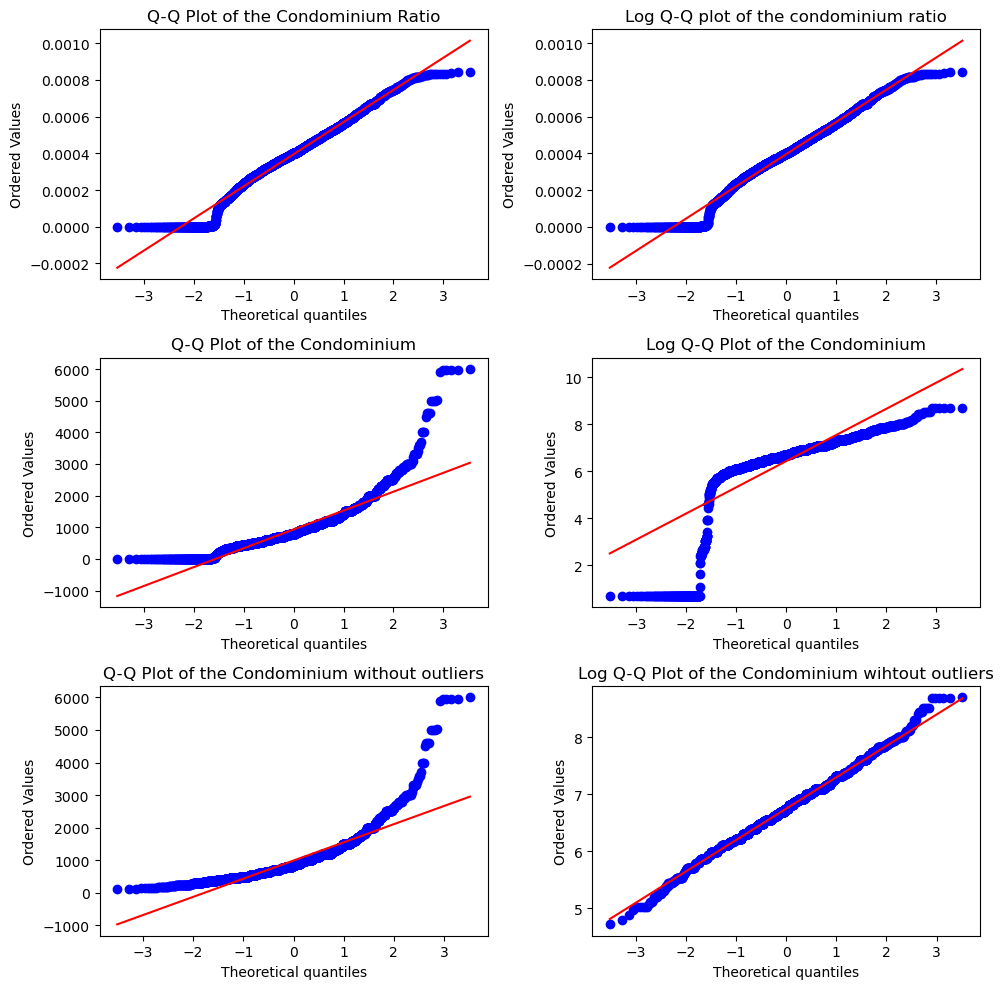

In [31]:
# Probability plots

fig, axs = plt.subplots(3, 2, figsize=(10,10), sharey=False)
axs = axs.reshape(1, -1)[0]

ax = axs[0]

stats.probplot(joint_df[Cols.Price_to_condominium_ratio.value], plot=ax)
ax.set_title('Q-Q Plot of the Condominium Ratio')

ax = axs[1]

stats.probplot(np.log1p(joint_df[Cols.Price_to_condominium_ratio.value]), plot=ax)
ax.set_title('Log Q-Q plot of the condominium ratio');

# Probability plots without outliers
ax = axs[2]

stats.probplot(joint_df[Cols.Condominium.value], plot=ax)
ax.set_title('Q-Q Plot of the Condominium')

ax = axs[3]

stats.probplot(np.log1p(joint_df[Cols.Condominium.value]), plot=ax)
ax.set_title('Log Q-Q Plot of the Condominium');

# Probability plots without outliers
ax = axs[4]

stats.probplot(joint_df.loc[joint_df[Cols.Condominium.value] > 100,Cols.Condominium.value], plot=ax)
ax.set_title('Q-Q Plot of the Condominium without outliers')

ax = axs[5]

stats.probplot(np.log1p(joint_df.loc[joint_df[Cols.Condominium.value] > 100,Cols.Condominium.value]), plot=ax)
ax.set_title('Log Q-Q Plot of the Condominium wihtout outliers');

fig.tight_layout()

#### 2.1.2.1 Inference

1. There are a lot of very strong outliers, mostly deemed input errors
2. 75% of values are below 0.052% of the apartment price
3. To deal with the upper bound outliers we'll use the the 75% + 1.5 x the inter quartile range as suggested by experts as a threshold for what we'll consider a non-error and insert a np.NaN on values above this level.
4. For the lower bound of what we consider human error we'll use a value of R$100

### 2.1.3 Area

In [32]:
df[Cols.Area.value].describe()

count     12779.000000
mean        184.534549
std        1726.437112
min          10.000000
25%         120.000000
50%         143.000000
75%         190.000000
max      195000.000000
Name: area, dtype: float64

<AxesSubplot: title={'center': 'Zoomed in of area'}>

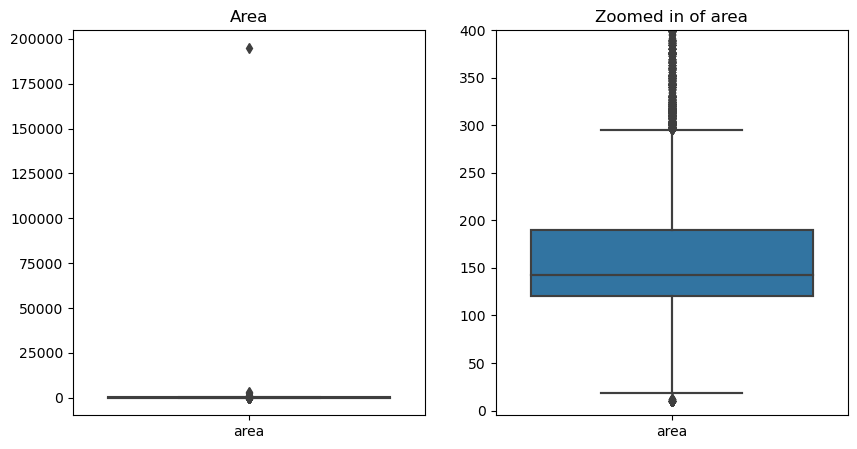

In [33]:
# Boxplots with the condominium fees and their ratios

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=False)
axs = axs.reshape(1, -1)[0]

# Area Boxplot
ax =axs[0]
sns.boxplot(data=df[Cols.Area.value].to_frame(), ax=ax)
ax.set(title='Area')

# zoomed in plot
ax = axs[1]

sns.boxplot(data=df[Cols.Area.value].to_frame(), ax=ax)
ax.set_ylim(top=400, bottom=-5)
ax.set(title='Zoomed in of area')

sns.boxplot(df[Cols.Area.value].to_frame())

In [34]:
print('Smallest areas')

df.sort_values(Cols.Area.value).head()

Smallest areas


,title,adress,condominium_fee,price,area,bedrooms,garage_spaces,bathrooms,test,tipo,bairro
id,,,,,,,,,,,
7256,"Apartamento com 3 Quartos à venda, 10m² - Centro","Rua 1001 - Centro, Balneário Camboriú - SC",NaN,1750000.0,10.0,3.0,3.0,4.0,False,Apartamento,Centro
7304,"Apartamento com 3 Quartos à venda, 10m² - Centro","Rua 1001 - Centro, Balneário Camboriú - SC",NaN,1970000.0,10.0,3.0,3.0,4.0,False,Apartamento,Centro
8267,"Apartamento com 4 Quartos à venda, 10m² - Centro","Centro, Balneário Camboriú - SC",NaN,2200000.0,10.0,4.0,2.0,3.0,False,Apartamento,Centro
8247,"Casa com 4 Quartos à venda, 10m² - Ariribá","Ariribá, Balneário Camboriú - SC",NaN,4700000.0,10.0,4.0,10.0,5.0,False,Casa,Ariribá
8241,"Apartamento com 1 Quarto à venda, 10m² - Centro","Centro, Balneário Camboriú - SC",NaN,490000.0,10.0,1.0,NaN,1.0,False,Apartamento,Centro


In [35]:
print('Biggest areas')

df.sort_values(Cols.Area.value).tail()

Biggest areas


,title,adress,condominium_fee,price,area,bedrooms,garage_spaces,bathrooms,test,tipo,bairro
id,,,,,,,,,,,
5245,"Casa com 3 Quartos à venda, 1200m² - Barra","Avenida Rodesindo Pavan, 7200 - Barra, Balneár...",NaN,14000000.0,1200.0,3.0,5.0,4.0,False,Casa,Barra
4508,"Apartamento com 3 Quartos à venda, 1219m² - Ce...","Centro, Balneário Camboriú - SC",773.0,1950000.0,1219.0,3.0,3.0,4.0,False,Apartamento,Centro
4288,"Casa com 3 Quartos à venda, 2886m² - Barra","Barra, Balneário Camboriú - SC",NaN,3980000.0,2886.0,3.0,10.0,5.0,False,Casa,Barra
4568,"Casa com 3 Quartos à venda, 3067m² - Barra","Barra, Balneário Camboriú - SC",NaN,8000000.0,3067.0,3.0,10.0,2.0,False,Casa,Barra
15094,"Casa com 3 Quartos à venda, 195000m² - Centro","Centro, Balneário Camboriú - SC",NaN,NaN,195000.0,3.0,NaN,3.0,True,Casa,Centro


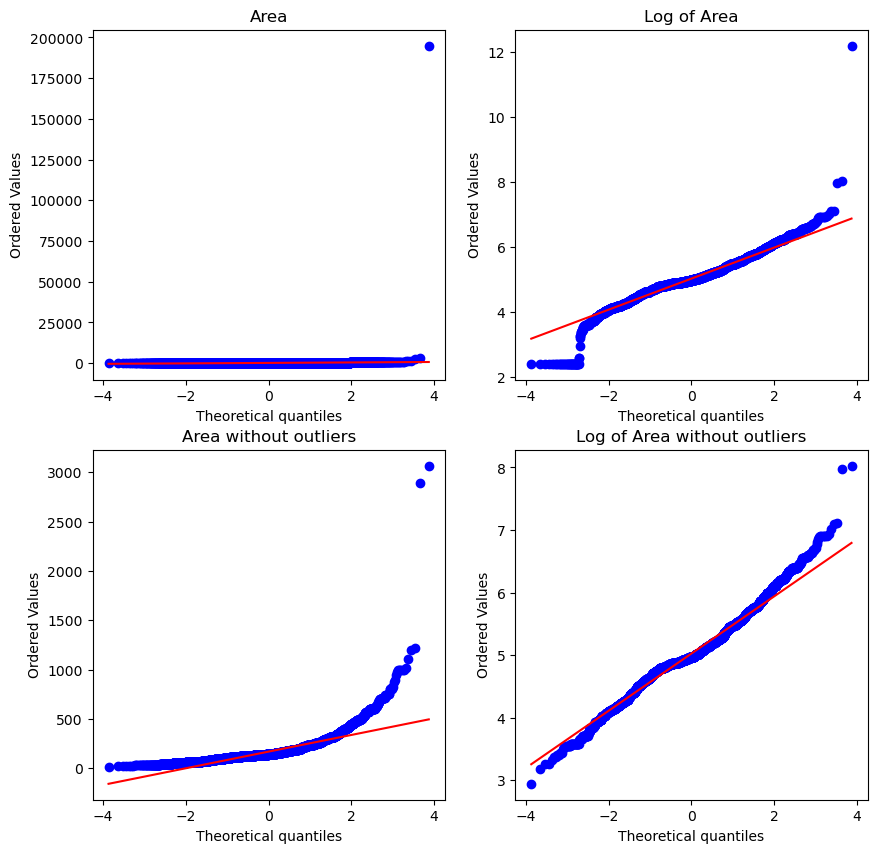

In [36]:
# Q-Q Plots

fig, axs = plt.subplots(2, 2, figsize=(10,10), sharey=False)
axs = axs.reshape(1, -1)[0]

# Area Q-Q Plot
ax =axs[0]
stats.probplot(df[Cols.Area.value], plot=ax);
ax.set(title='Area')

# Log Area Q-Q Plot
ax =axs[1]
stats.probplot(np.log1p(df[Cols.Area.value]), plot=ax);
ax.set(title='Log of Area');

lower_bound_area, upper_bound_area = extented_pandas.get_lower_and_upper_bounds_for_outliers(df[Cols.Area.value])

# Area Q-Q Plot without outliers
df_without_area_outliers = df[(df[Cols.Area.value] > lower_bound_area) & (df[Cols.Area.value] < 25_000)]
ax =axs[2]
stats.probplot(df_without_area_outliers[Cols.Area.value], plot=ax);
ax.set(title='Area without outliers')
 
# Log Area Q-Q Plot
ax =axs[3]
stats.probplot(np.log1p(df_without_area_outliers[Cols.Area.value]), plot=ax);
ax.set(title='Log of Area without outliers');

Inference:

1. There are heavy outliers on both ends, on the lower end we'll use the Q25 - 1,5*IQR rule as stated before, on the higher end we'll leave as is since there were no errors detected.
2. The log of the area without outliers are fairly normal and will be used as such

In [37]:
# Removes small and big outliers in areas
@make_pipeline
def remove_small_and_big_areas(df_in: pd.DataFrame) -> pd.DataFrame:
	maximum_area = 25_000
	lower_bound_area, _ = extented_pandas.get_lower_and_upper_bounds_for_outliers(df_in[Cols.Area.value])
	values_before_removal = len(df_in)
	df_in = df_in[(df[Cols.Area.value] > lower_bound_area) & (df[Cols.Area.value] < maximum_area)]
	print(f'Number of entries removed because of the area: {values_before_removal - len(df_in)}')

	return df_in

df = pipeline_functions_dict['remove_small_and_big_areas'](df)
df.head()

Number of entries removed because of the area: 44


,title,adress,condominium_fee,price,area,bedrooms,garage_spaces,bathrooms,test,tipo,bairro
id,,,,,,,,,,,
1,"Cobertura com 3 Quartos à venda, 240m² - Centro","Rua 901 - Centro, Balneário Camboriú - SC",NaN,4200000.0,240.0,3.0,2.0,1.0,False,Cobertura,Centro
2,"Apartamento com 4 Quartos à venda, 167m² - Centro","Rua 2950 - Centro, Balneário Camboriú - SC",NaN,3418419.0,167.0,4.0,3.0,2.0,False,Apartamento,Centro
3,"Apartamento com 4 Quartos à venda, 149m² - Centro","Rua 3140 - Centro, Balneário Camboriú - SC",NaN,2400000.0,149.0,4.0,2.0,1.0,False,Apartamento,Centro
4,"Apartamento com 4 Quartos à venda, 129m² - Centro","Avenida do Estado Dalmo Vieira - Centro, Balne...",NaN,2751000.0,129.0,4.0,2.0,2.0,False,Apartamento,Centro
5,"Apartamento com 3 Quartos à venda, 118m² - Centro","Rua 1901 - Centro, Balneário Camboriú - SC",NaN,2398000.0,118.0,3.0,2.0,1.0,False,Apartamento,Centro


### 2.1.4 Bedrooms, Garage spaces and Bathrooms	

#### 2.1.4.1 Filling NAs

In [38]:
# Total NA
df.loc[:, [Cols.Bedrooms.value, Cols.Garages.value, Cols.Bathrooms.value]].isna().sum()

bedrooms           0
garage_spaces    388
bathrooms          0
dtype: int64

In [39]:
df[Cols.Garages.value].describe()

count    12347.000000
mean         2.507816
std          1.267546
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         33.000000
Name: garage_spaces, dtype: float64

In [40]:
(df[Cols.Area.value] / df[Cols.Garages.value]).describe()

count    12347.000000
mean        74.511503
std         37.010423
min          4.166667
25%         50.333333
50%         64.000000
75%         86.000000
max        555.500000
dtype: float64

In [41]:
mask_empty_garages = df[Cols.Garages.value].isna()
df[mask_empty_garages][Cols.Area.value].describe()

count     388.000000
mean      140.817010
std       102.207116
min        29.000000
25%        70.750000
50%       128.000000
75%       167.250000
max      1000.000000
Name: area, dtype: float64

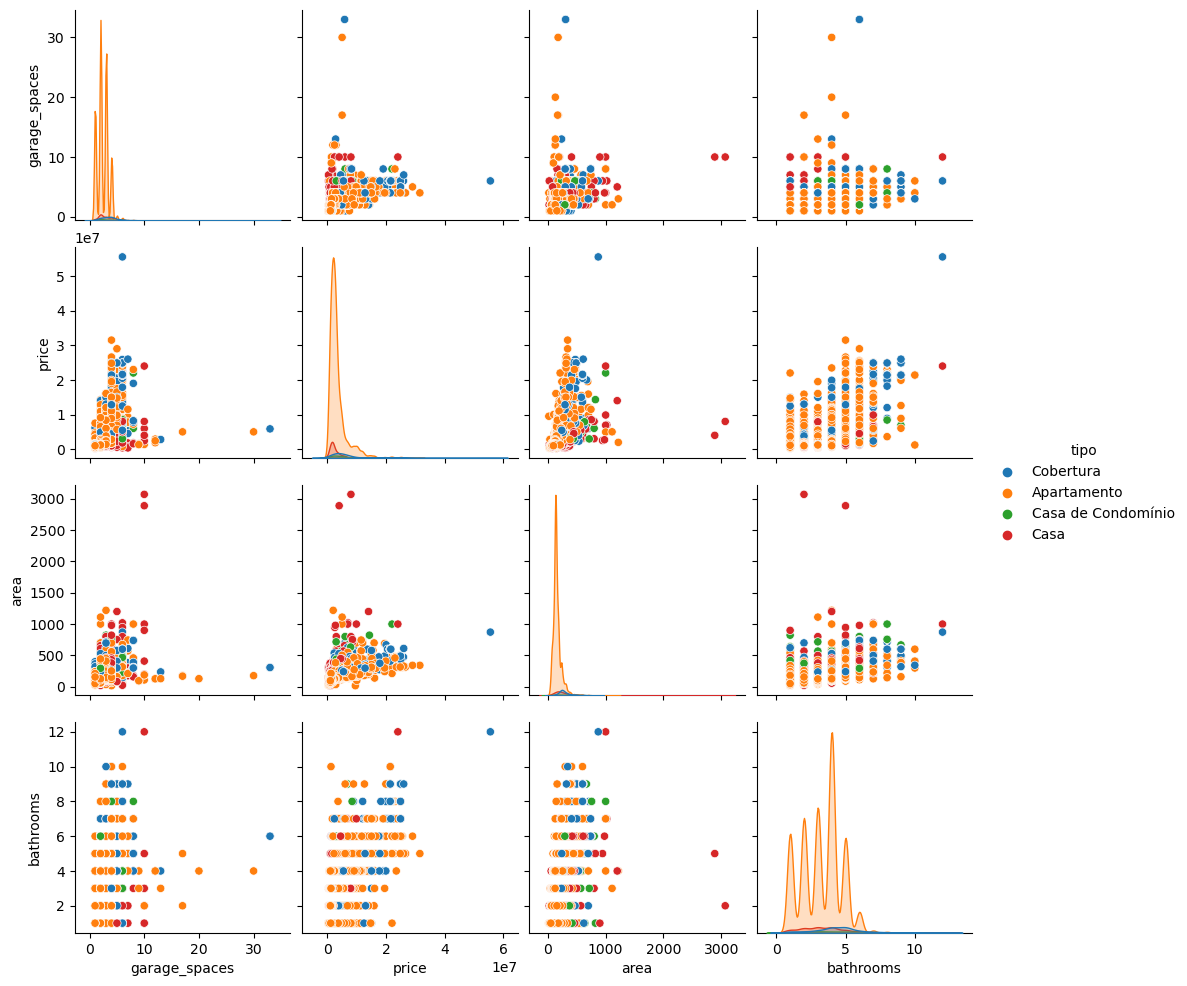

In [42]:
# Pairplots to check later with newly inputted data if any outliers were created

columns_pairplot = [Cols.Garages.value, Cols.Price.value, Cols.Area.value, Cols.Bathrooms.value, Cols.Type.value]
sns.pairplot(data=df[columns_pairplot], hue=Cols.Type.value)

##### 2.1.4.1.1 Inference

1. Only garage has NA in these features
2. For the inputation we'll use a simple ratio with the area using the mean (74.5m² per Garage), with an upper ratio of 5 garages

In [43]:
# Fill NA garages

@make_pipeline
def input_empty_garages(df_in:pd.DataFrame) -> pd.DataFrame:
    mean_garage_per_m2 = (df_in[Cols.Area.value] / df_in[Cols.Garages.value]).mean()
    mask_empty_garages = df_in[Cols.Garages.value].isna()
    garages_inputation = np.round(df_in.loc[mask_empty_garages, Cols.Area.value] / mean_garage_per_m2, 0)
    
    _, upper_bound_garages = np.ceil(extented_pandas.get_lower_and_upper_bounds_for_outliers(df_in[Cols.Garages.value]))
    garages_inputation[garages_inputation > upper_bound_garages] = upper_bound_garages
    df.loc[garages_inputation.index, Cols.Garages.value] = garages_inputation
    
    return df

df = pipeline_functions_dict['input_empty_garages'](df)

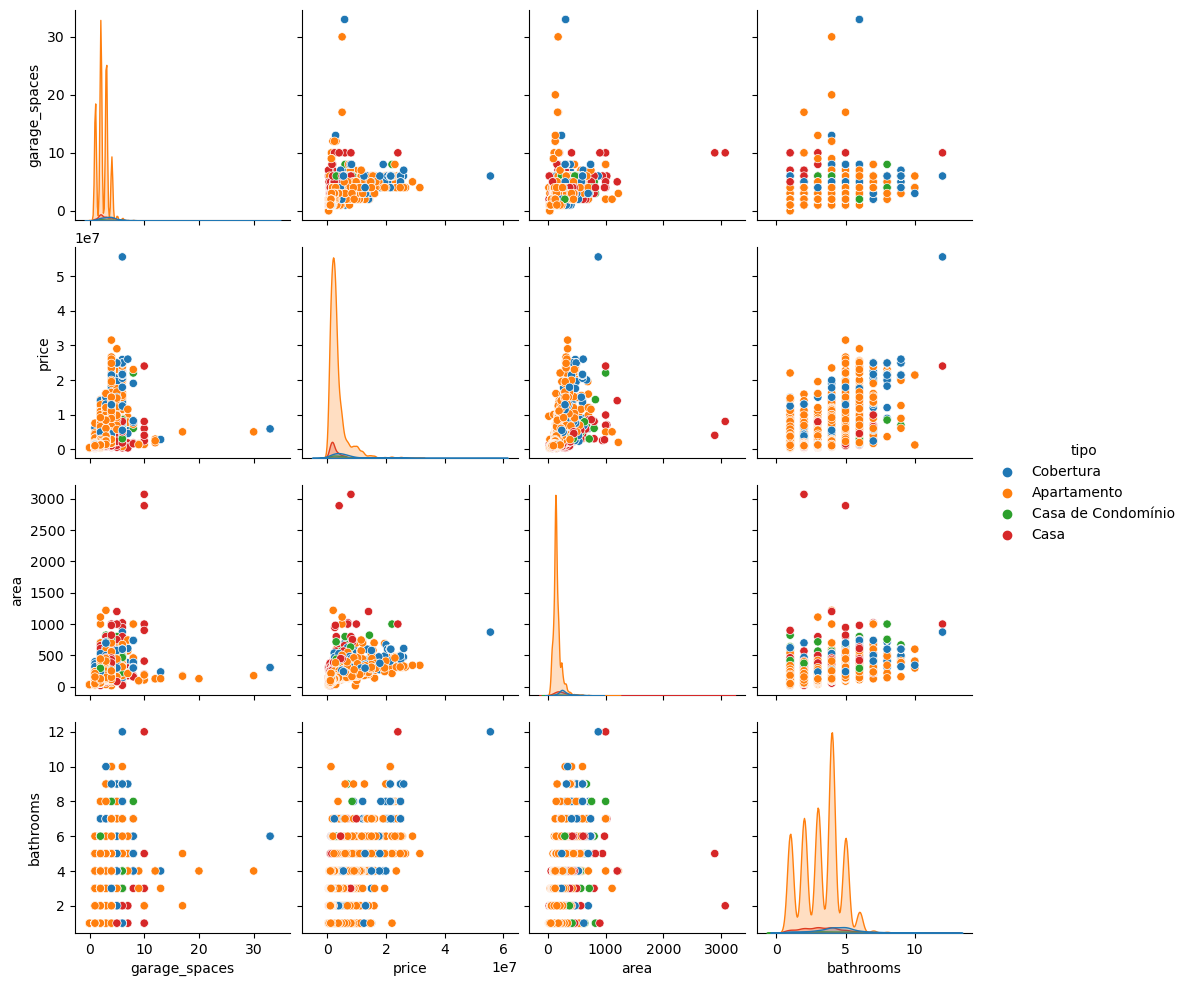

In [44]:
# Pairplot with newly inputted data to check if any outlier or anomalies were created during inputation

sns.pairplot(data=df[columns_pairplot], hue=Cols.Type.value)

The inserted data doesn't seem to have created any new outliers or anomalities

#### 2.1.4.2 Exploration

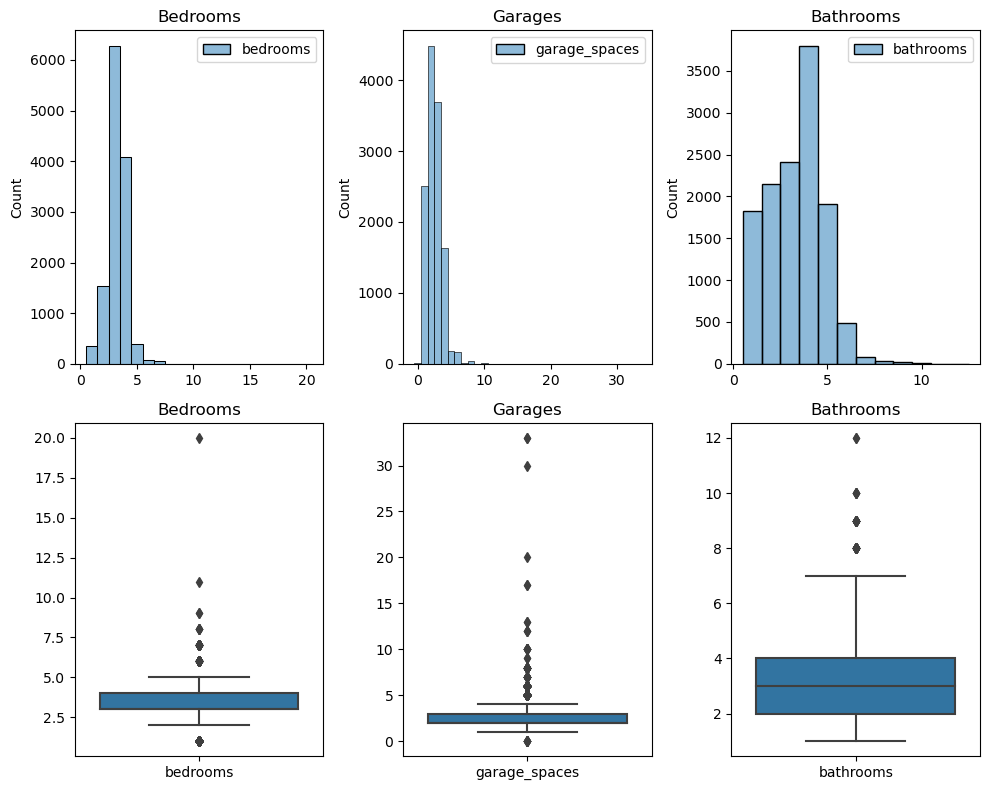

In [45]:
# Barcharts and boxplots

fig, axs = plt.subplots(2, 3, figsize=(10,8), sharey=False)
axs = iter(axs.reshape(1, -1)[0])

# Bedrooms
ax = next(axs)
sns.histplot(data=df[Cols.Bedrooms.value].to_frame(), ax=ax, discrete=True)
ax.set(title='Bedrooms')

# Garages
ax = next(axs)

sns.histplot(data=df[Cols.Garages.value].to_frame(), ax=ax, discrete=True)
ax.set(title='Garages')

# Bathrooms
ax = next(axs)

sns.histplot(data=df[Cols.Bathrooms.value].to_frame(), ax=ax, discrete=True)
ax.set(title='Bathrooms');

# Bedrooms
ax = next(axs)
sns.boxplot(data=df[Cols.Bedrooms.value].to_frame(), ax=ax)
ax.set(title='Bedrooms')

# Garages
ax = next(axs)

sns.boxplot(data=df[Cols.Garages.value].to_frame(), ax=ax)
ax.set(title='Garages')

# Bathrooms
ax = next(axs)

sns.boxplot(data=df[Cols.Bathrooms.value].to_frame(), ax=ax)
ax.set(title='Bathrooms');

fig.tight_layout()

In [46]:
df.loc[df['test'] == False, Cols.Garages.value].value_counts().sort_index()

0.0        3
1.0     1516
2.0     2787
3.0     2353
4.0     1033
5.0      124
6.0      126
7.0       12
8.0       22
9.0        2
10.0       7
12.0       3
13.0       1
17.0       1
30.0       1
33.0       1
Name: garage_spaces, dtype: int64

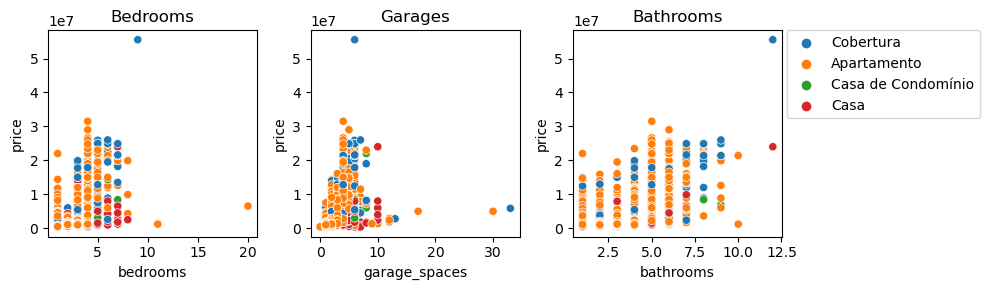

In [47]:
# Scatterplots

fig, axs = plt.subplots(1, 3, figsize=(10,3), sharey=False)

axs = iter(axs.reshape(1, -1)[0])

# Bedrooms
ax = next(axs)
sns.scatterplot(data=df, x=Cols.Bedrooms.value, y=Cols.Price.value, hue=Cols.Type.value, ax=ax, legend=False)
ax.set(title='Bedrooms')

# Garages
ax = next(axs)

sns.scatterplot(data=df, x=Cols.Garages.value, y=Cols.Price.value, hue=Cols.Type.value, ax=ax, legend=False)
ax.set(title='Garages')

# Bathrooms
ax = next(axs)

sns.scatterplot(data=df, x=Cols.Bathrooms.value, y=Cols.Price.value, hue=Cols.Type.value, ax=ax)
ax.set(title='Bathrooms');

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

fig.tight_layout()

#### 2.1.4.1 Inference

1. There are no big outliers in these features
2. They will be used as is

### 2.1.5 Correlations

C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\3815913981.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.drop(columns=Cols.Test.value).corr(), square=True, annot=True, annot_kws={'size':10})


<AxesSubplot: >

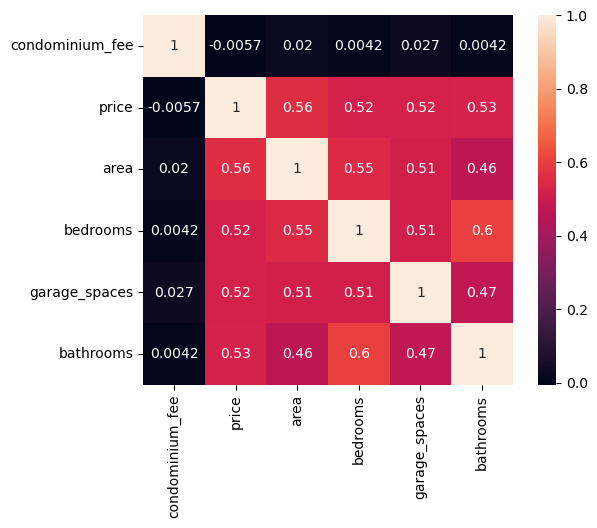

In [48]:
sns.heatmap(df.drop(columns=Cols.Test.value).corr(), square=True, annot=True, annot_kws={'size':10})

#### 2.1.5.1 Inference

1. Condominium Fee appears to have no relation to price, we'll wait till the analysis of the amenities to decide if we'll discard this feature

## 2.2 Categorical Features

### 2.2.1 District

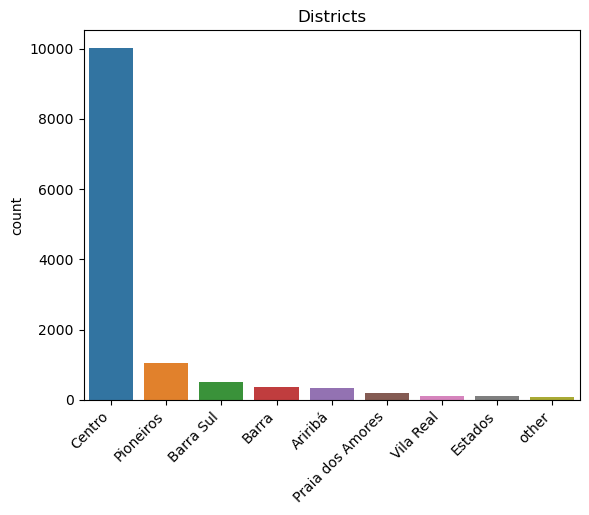

In [49]:
ax = sns.countplot(data=df,
                   x=Cols.District.value, 
                   order=df[Cols.District.value].value_counts().index.tolist()
)

ax.set(xlabel=None, title='Districts')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\3191560219.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  distric_boxplot_order = df.groupby(by=Cols.District.value) \
C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\3191560219.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


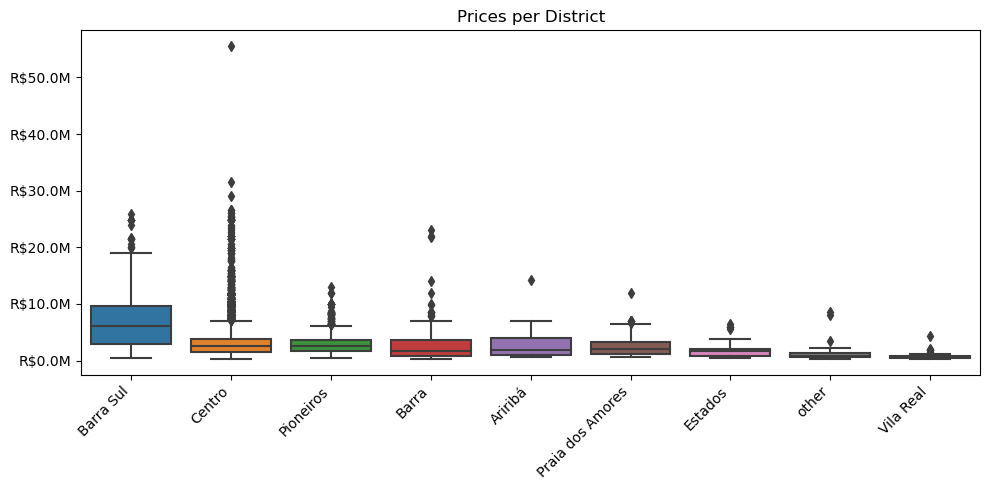

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), sharey=True)

distric_boxplot_order = df.groupby(by=Cols.District.value) \
    .mean() \
	.sort_values(by=Cols.Price.value, ascending=False) \
	.index \
	.to_list()

sns.boxplot(data=df, x=Cols.District.value, y=Cols.Price.value, ax=ax, order=distric_boxplot_order)

ax.set_title('Prices per District')

ylabels = ['R${:,.1f}'.format(x) + 'M' for x in ax.get_yticks()/1_000_000]
ax.set_yticklabels(ylabels)

ax.set(xlabel=None, ylabel=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

fig.tight_layout()

#### 2.2.1.1 Inference

1. Barra Sul is the most expensive District in average, but Centro has the most expensive entries
2. Vila Real is the cheapest in average
3. Centro has a big range, from 250.000 to 55.000.000

In [51]:
pd.get_dummies(df[Cols.District.value], prefix='district_')

,district__Ariribá,district__Barra,district__Barra Sul,district__Centro,district__Estados,district__Pioneiros,district__Praia dos Amores,district__Vila Real,district__other
id,,,,,,,,,
1,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
15714,0,0,0,1,0,0,0,0,0
15716,0,0,0,1,0,0,0,0,0
15717,0,0,0,1,0,0,0,0,0


### 2.2.2 Type

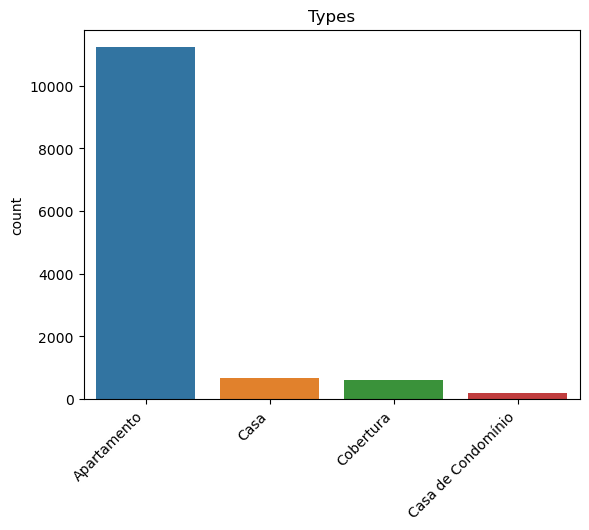

In [52]:
ax = sns.countplot(data=df,
                   x=Cols.Type.value, 
                   order=df[Cols.Type.value].value_counts().index.tolist()
)

ax.set(xlabel=None, title='Types')


ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\3653645075.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  distric_boxplot_order = df.groupby(by=Cols.Type.value) \
C:\Users\Kriggs\AppData\Local\Temp\ipykernel_15844\3653645075.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


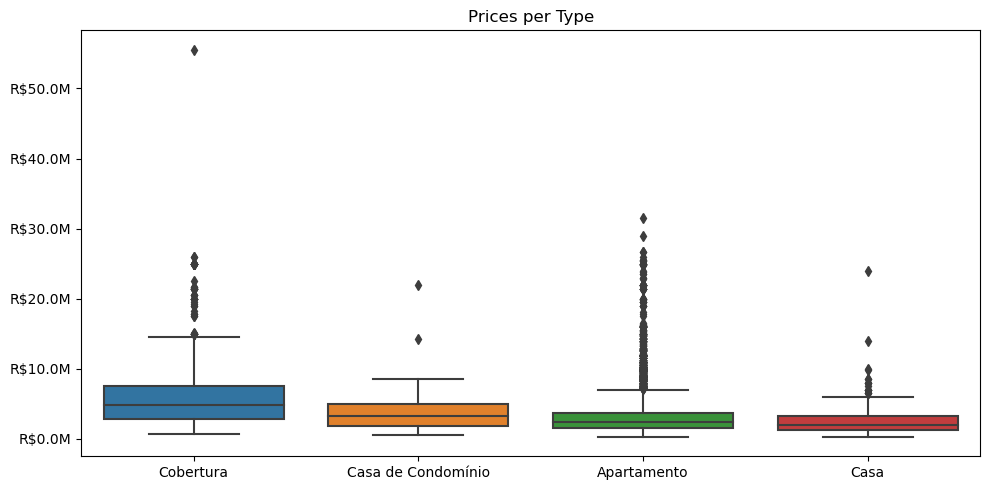

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), sharey=True)

distric_boxplot_order = df.groupby(by=Cols.Type.value) \
    .mean() \
	.sort_values(by=Cols.Price.value, ascending=False) \
	.index \
	.to_list()

sns.boxplot(data=df, x=Cols.Type.value, y=Cols.Price.value, ax=ax, order=distric_boxplot_order)

ax.set_title('Prices per Type')

ylabels = ['R${:,.1f}'.format(x) + 'M' for x in ax.get_yticks()/1_000_000]
ax.set_yticklabels(ylabels)

ax.set(xlabel=None, ylabel=None)

fig.tight_layout()

#### 2.2.2.1 Inference

1. Apartment is the most commom type
2. Cobertura is the most expensive both in average and maximum

### 2.2.3 Amenities

In [54]:
df_amenities.shape

(15402, 167)

In [55]:
# Summing and sorting amenities by most ocurring

sum_amenities = df_amenities.sum() \
    .sort_values(ascending=False) \
	.to_frame(name='Sum')

sum_amenities.head()

,Sum
churrasqueira,7190
salão_de_festas,5929
piscina,5718
área_de_serviço,5349
academia,5071


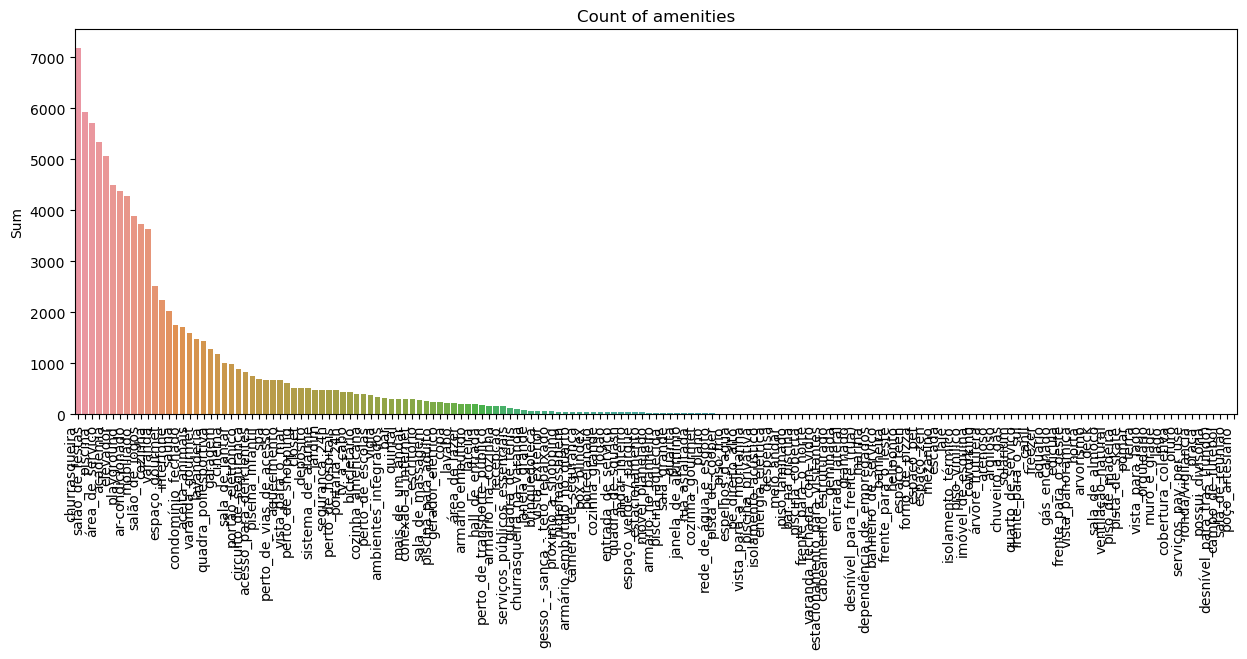

In [56]:
# Plotting all amenities sum to bar graph

fig, ax = plt.subplots(1, 1, figsize=(15,5), sharey=True)

sns.barplot(data=sum_amenities, x=sum_amenities.index, y='Sum', ax=ax)

ax.set_title('Count of amenities')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right');

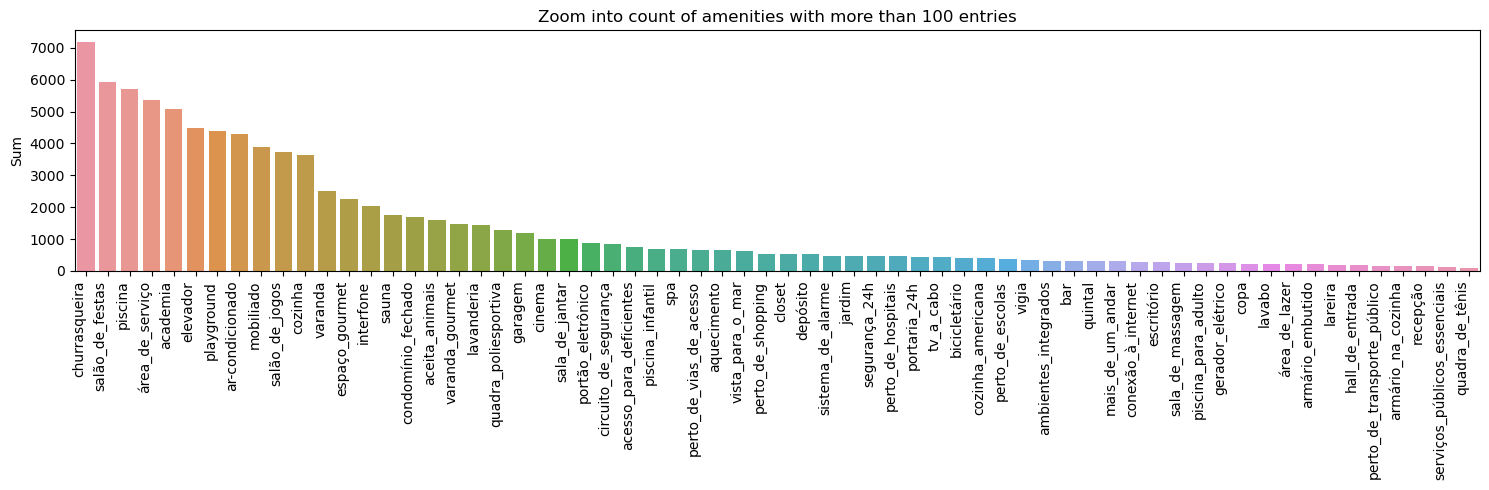

In [57]:
# Zooming in plot of all amenities sum to bar graph

fig, ax = plt.subplots(1, 1, figsize=(15,5), sharey=True)

sum_amenities_with_more_than_100 = sum_amenities[sum_amenities > 100].dropna()

sns.barplot(data=sum_amenities_with_more_than_100, x=sum_amenities_with_more_than_100.index, y='Sum', ax=ax)

ax.set_title('Zoom into count of amenities with more than 100 entries')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right');

fig.tight_layout()

In [58]:
# Add amenities to main dataframe
df_joint_amenities = pd.merge(left=df, right=df_amenities, left_index=True, right_index=True)

# Drop NA prices
df_joint_amenities = df_joint_amenities[~df_joint_amenities[Cols.Price.value].isna()]

In [59]:
# Apply A/B Testing

ab = []

with warnings.catch_warnings():
	warnings.simplefilter(action="ignore", category=UserWarning)
	
	for i in sum_amenities_with_more_than_100.index.tolist():
		ab.append(extented_pandas.AB_Test(dataframe=df_joint_amenities, group = i, target = Cols.Price.value));
	
ab = pd.concat(ab).set_index('Feature').sort_values('p-value', ascending=False);

ab.head(20)

,Test Type,AB Hypothesis,p-value,Comment,GroupA_mean,GroupB_mean,GroupA_median,GroupB_median
Feature,,,,,,,,
perto_de_vias_de_acesso,Non-Parametric,Fail to Reject H0,0.914842,A/B groups are similar!,3.493229e+06,3.454668e+06,2400000.0,2449000.0
lavabo,Non-Parametric,Fail to Reject H0,0.838551,A/B groups are similar!,3.162515e+06,3.460305e+06,2400000.0,2430142.0
copa,Non-Parametric,Fail to Reject H0,0.608859,A/B groups are similar!,3.429938e+06,3.457394e+06,2500000.0,2412500.0
garagem,Non-Parametric,Fail to Reject H0,0.579170,A/B groups are similar!,3.466680e+06,3.456298e+06,2397000.0,2440500.0
cozinha,Non-Parametric,Fail to Reject H0,0.496843,A/B groups are similar!,3.316933e+06,3.510588e+06,2450000.0,2400000.0
tv_a_cabo,Non-Parametric,Fail to Reject H0,0.453305,A/B groups are similar!,3.192126e+06,3.465895e+06,2300000.0,2450000.0
perto_de_shopping,Non-Parametric,Fail to Reject H0,0.442615,A/B groups are similar!,3.682634e+06,3.444693e+06,2530000.0,2400000.0
varanda_gourmet,Non-Parametric,Fail to Reject H0,0.387145,A/B groups are similar!,3.393713e+06,3.464076e+06,2300000.0,2450000.0
área_de_lazer,Non-Parametric,Fail to Reject H0,0.357330,A/B groups are similar!,2.913605e+06,3.464153e+06,2105000.0,2450000.0


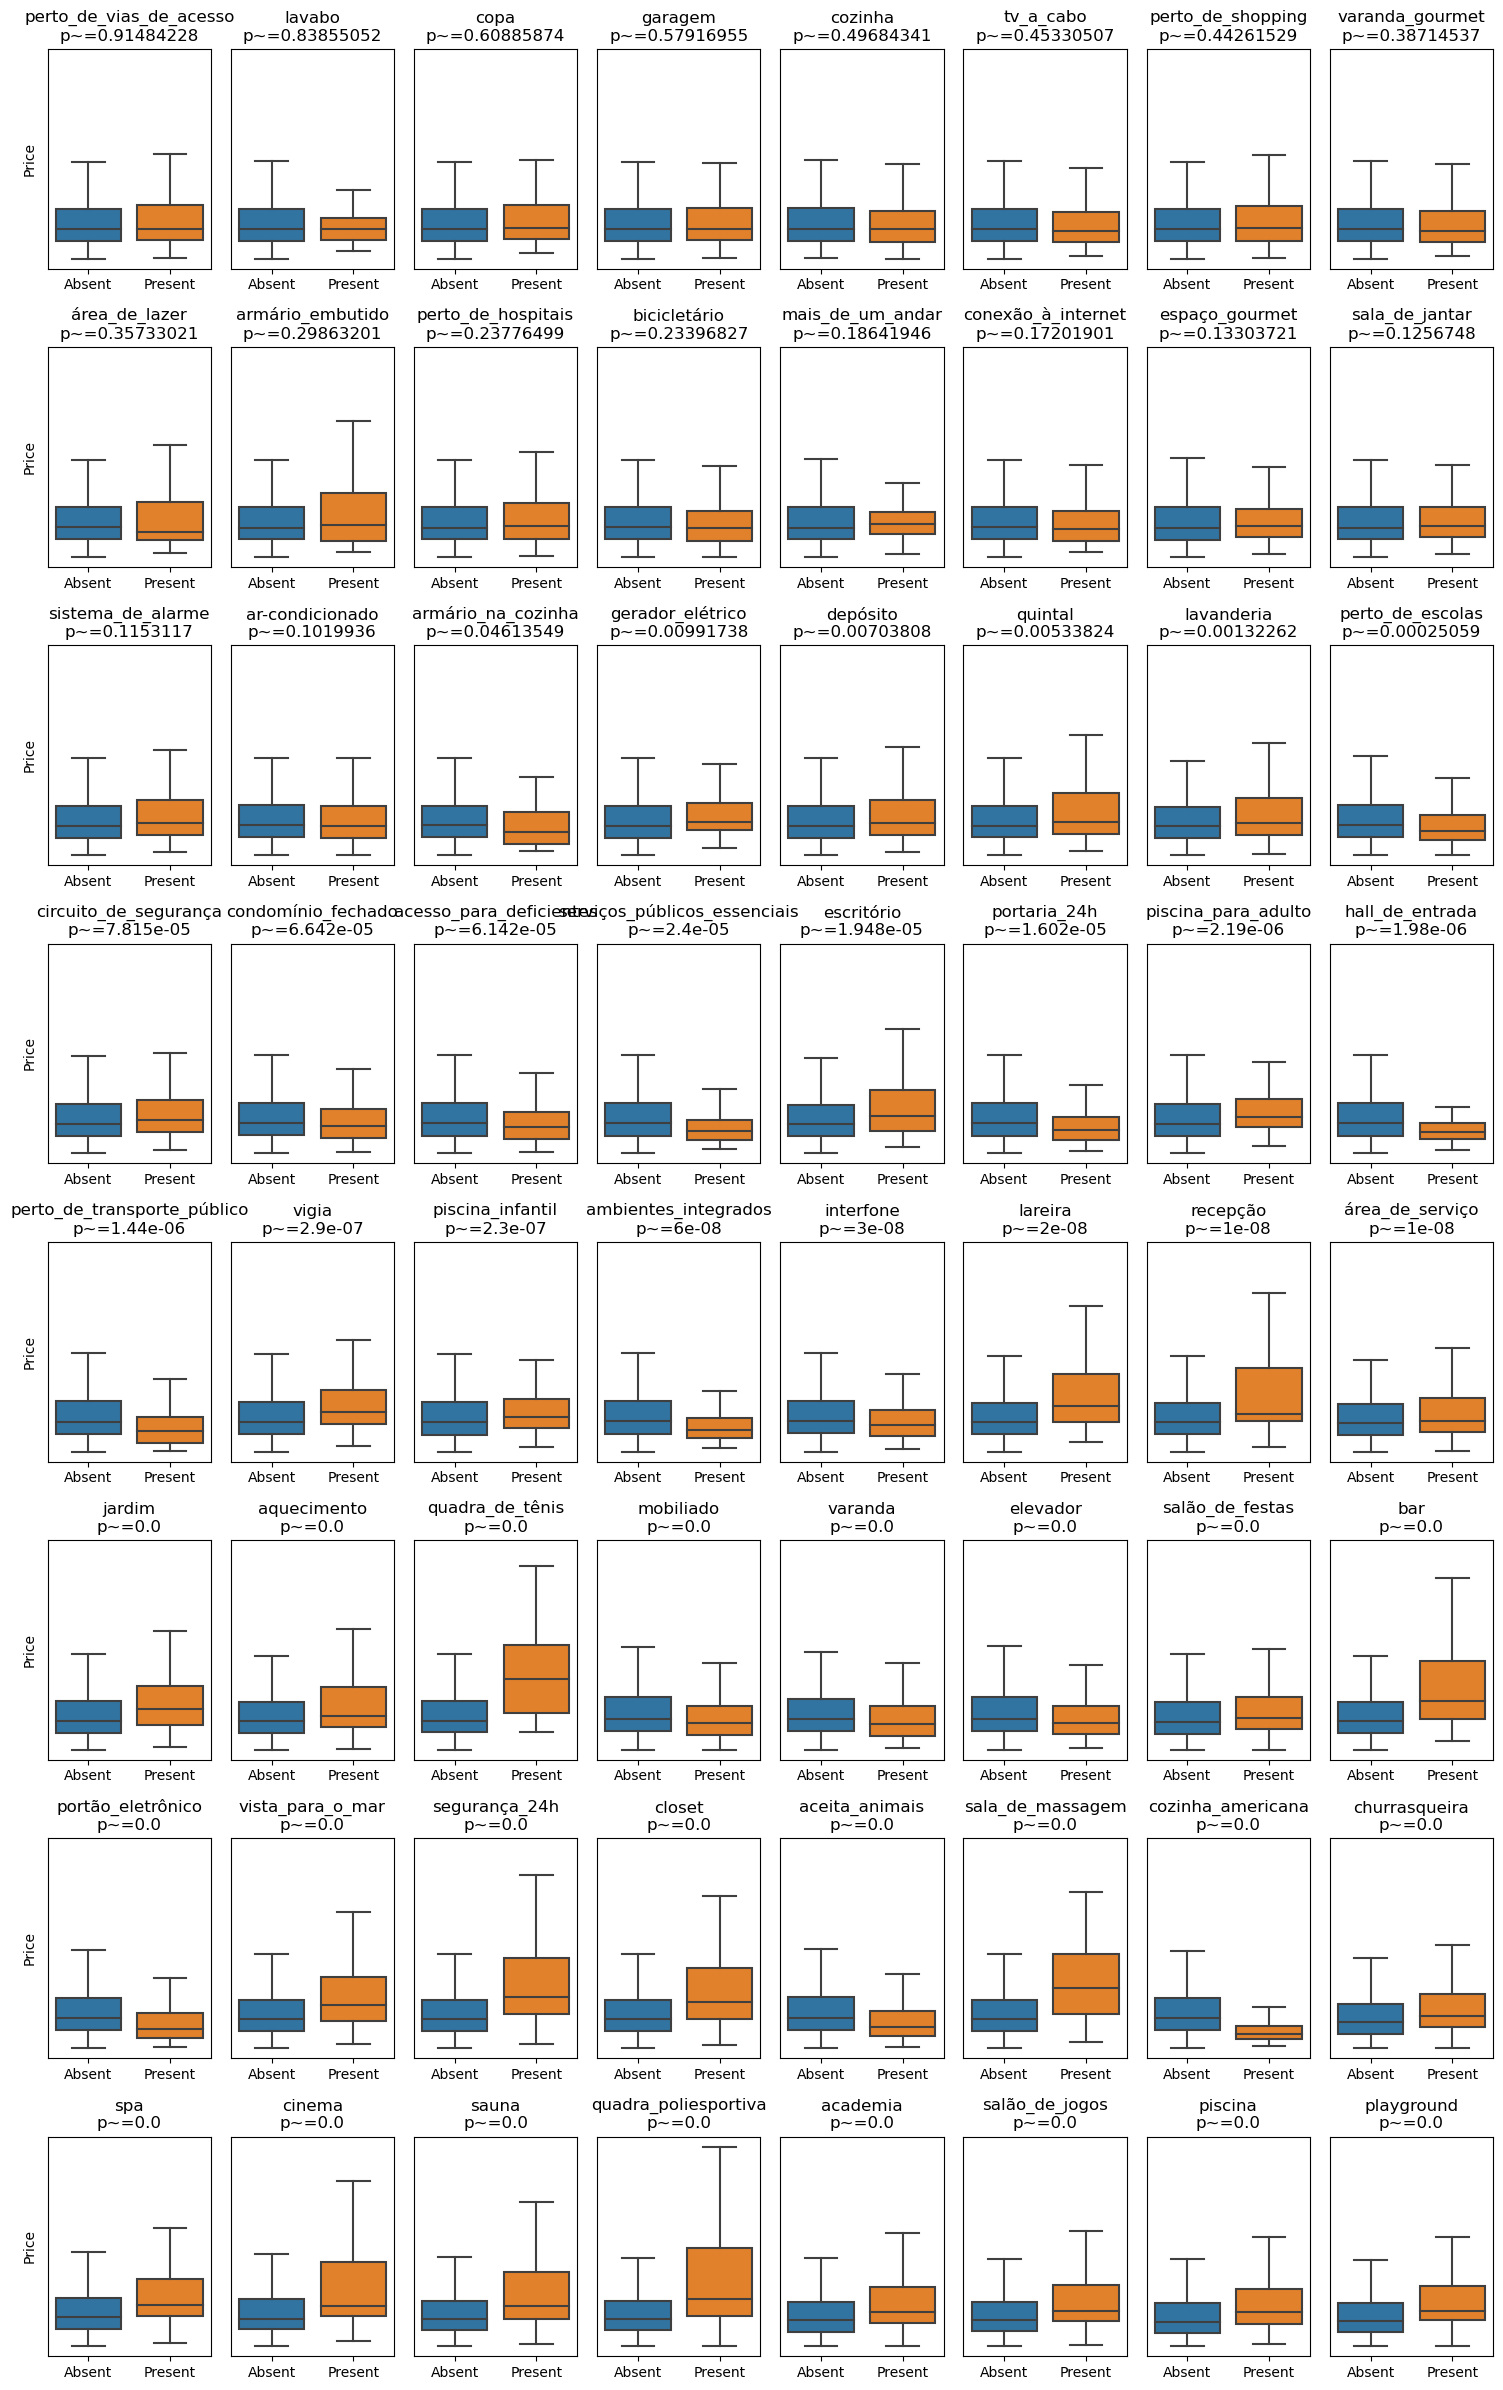

In [60]:
# Boxplots of the amenities features

amenities_to_graph = ab.index.to_list()

num_cols = 8
num_rows = int(np.ceil(len(amenities_to_graph) / num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15,3*num_rows), sharey=True)
axs = iter(axs.reshape(1, -1)[0])

for i_ax, col in enumerate(amenities_to_graph):
	ax = next(axs)
	sns.boxplot(data=df_joint_amenities, x=col, y=Cols.Price.value, ax=ax, showfliers=False)
	
	ax.set_title(f'{col}\np~={np.round(ab.loc[col, "p-value"], 8)}')
	ax.set(xlabel=None,
		   xticks=[0,1],
		   xticklabels=['Absent', 'Present'],
		   yticks=[],
		   # Price label only in the leftmost graph
		   ylabel='Price' if i_ax % num_cols == 0 else None
	)
	
	ax.relim()

fig.tight_layout()

The graph above shows us the difference in price for every ammenity item in the appartments, we'll be using the ones with the lowest p-values (below 0.05), this means that we are 95% confident that the groups with and without this feature are different, and will yield better results in our models:

In [61]:
# Get list of relevant amenities thorugh A/B testing columns and append to DF
@make_pipeline
def set_amenities_columns(df_main: pd.DataFrame, df_in_amenities: pd.DataFrame) -> pd.DataFrame:
	# Reduce amenities Dataframe to only columns with more than 100 positive values, as to not overfit
	sum_amenities = df_in_amenities.sum() \
		.sort_values(ascending=False) \
		.to_frame(name='Sum')

	relevant_columns = sum_amenities[sum_amenities > 100].dropna().index
	df_in_amenities = df_in_amenities[relevant_columns]

	# Add amenities to main dataframe
	df_joint_amenities = pd.merge(left=df_main, right=df_in_amenities, left_index=True, right_index=True)

	# Drop NA prices
	df_joint_amenities = df_joint_amenities[~df_joint_amenities[Cols.Price.value].isna()]

	# Apply A/B Testing
	ab = []

	with warnings.catch_warnings():
		warnings.simplefilter(action="ignore", category=UserWarning)
		
		for i in sum_amenities_with_more_than_100.index.tolist():
			ab.append(extented_pandas.AB_Test(dataframe=df_joint_amenities, group = i, target = Cols.Price.value));
		
	ab = pd.concat(ab).set_index('Feature').sort_values('p-value', ascending=False);

	# Get list of features below the 95% confidence level
	irrelevant_features = ab[ab['p-value'] > 0.05].index

	# Drop all columns in this confidence level
	return pd.merge(left=df_main, right=df_in_amenities, left_index=True, right_index=True).drop(columns=irrelevant_features)

df = pipeline_functions_dict['set_amenities_columns'](df, df_amenities)
df.head()

,title,adress,condominium_fee,price,area,bedrooms,garage_spaces,bathrooms,test,tipo,bairro,churrasqueira,salão_de_festas,piscina,área_de_serviço,academia,elevador,playground,mobiliado,salão_de_jogos,varanda,interfone,sauna,condomínio_fechado,aceita_animais,lavanderia,quadra_poliesportiva,cinema,portão_eletrônico,circuito_de_segurança,acesso_para_deficientes,piscina_infantil,spa,aquecimento,vista_para_o_mar,closet,depósito,jardim,segurança_24h,portaria_24h,cozinha_americana,perto_de_escolas,vigia,ambientes_integrados,bar,quintal,escritório,sala_de_massagem,piscina_para_adulto,gerador_elétrico,lareira,hall_de_entrada,perto_de_transporte_público,armário_na_cozinha,recepção,serviços_públicos_essenciais,quadra_de_tênis
1,"Cobertura com 3 Quartos à venda, 240m² - Centro","Rua 901 - Centro, Balneário Camboriú - SC",NaN,4200000.0,240.0,3.0,2.0,1.0,False,Cobertura,Centro,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Apartamento com 4 Quartos à venda, 167m² - Centro","Rua 2950 - Centro, Balneário Camboriú - SC",NaN,3418419.0,167.0,4.0,3.0,2.0,False,Apartamento,Centro,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Apartamento com 4 Quartos à venda, 149m² - Centro","Rua 3140 - Centro, Balneário Camboriú - SC",NaN,2400000.0,149.0,4.0,2.0,1.0,False,Apartamento,Centro,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Apartamento com 4 Quartos à venda, 129m² - Centro","Avenida do Estado Dalmo Vieira - Centro, Balne...",NaN,2751000.0,129.0,4.0,2.0,2.0,False,Apartamento,Centro,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,"Apartamento com 3 Quartos à venda, 118m² - Centro","Rua 1901 - Centro, Balneário Camboriú - SC",NaN,2398000.0,118.0,3.0,2.0,1.0,False,Apartamento,Centro,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Data Transformation

## Categorical Data

Since our models can't deal with text data, we'll transform the categorical columns into their own "on/off" columns and drop the title and address as they have already been transformed into other colunns:

In [62]:
# Tranform categorical data into 0/1 variables
@make_pipeline
def set_dummies_for_categoricals(df_in: pd.DataFrame) -> pd.DataFrame:
	cols_prefixs = {
		Cols.Type.value: 'type_',
		Cols.District.value: 'district_'
	}

	if set(cols_prefixs.keys()).issubset(df_in.columns): # Checks if columns still exist
		return pd.get_dummies(data=df_in, columns=cols_prefixs.keys(), prefix=cols_prefixs, drop_first=True)
	else:
		return df_in

	
df = pipeline_functions_dict['set_dummies_for_categoricals'](df)
df.head()

,title,adress,condominium_fee,price,area,bedrooms,garage_spaces,bathrooms,test,churrasqueira,salão_de_festas,piscina,área_de_serviço,academia,elevador,playground,mobiliado,salão_de_jogos,varanda,interfone,sauna,condomínio_fechado,aceita_animais,lavanderia,quadra_poliesportiva,cinema,portão_eletrônico,circuito_de_segurança,acesso_para_deficientes,piscina_infantil,spa,aquecimento,vista_para_o_mar,closet,depósito,jardim,segurança_24h,portaria_24h,cozinha_americana,perto_de_escolas,vigia,ambientes_integrados,bar,quintal,escritório,sala_de_massagem,piscina_para_adulto,gerador_elétrico,lareira,hall_de_entrada,perto_de_transporte_público,armário_na_cozinha,recepção,serviços_públicos_essenciais,quadra_de_tênis,type__Casa,type__Casa de Condomínio,type__Cobertura,district__Barra,district__Barra Sul,district__Centro,district__Estados,district__Pioneiros,district__Praia dos Amores,district__Vila Real,district__other
1,"Cobertura com 3 Quartos à venda, 240m² - Centro","Rua 901 - Centro, Balneário Camboriú - SC",NaN,4200000.0,240.0,3.0,2.0,1.0,False,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,"Apartamento com 4 Quartos à venda, 167m² - Centro","Rua 2950 - Centro, Balneário Camboriú - SC",NaN,3418419.0,167.0,4.0,3.0,2.0,False,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,"Apartamento com 4 Quartos à venda, 149m² - Centro","Rua 3140 - Centro, Balneário Camboriú - SC",NaN,2400000.0,149.0,4.0,2.0,1.0,False,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,"Apartamento com 4 Quartos à venda, 129m² - Centro","Avenida do Estado Dalmo Vieira - Centro, Balne...",NaN,2751000.0,129.0,4.0,2.0,2.0,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,"Apartamento com 3 Quartos à venda, 118m² - Centro","Rua 1901 - Centro, Balneário Camboriú - SC",NaN,2398000.0,118.0,3.0,2.0,1.0,False,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [63]:
# Drop title, address columns
@make_pipeline
def drop_title_and_address_columns(df_in:pd.DataFrame) -> pd.DataFrame:
    return df_in.drop(columns=[Cols.Address.value, Cols.Title.value])

df = pipeline_functions_dict['drop_title_and_address_columns'](df)
df

,condominium_fee,price,area,bedrooms,garage_spaces,bathrooms,test,churrasqueira,salão_de_festas,piscina,área_de_serviço,academia,elevador,playground,mobiliado,salão_de_jogos,varanda,interfone,sauna,condomínio_fechado,aceita_animais,lavanderia,quadra_poliesportiva,cinema,portão_eletrônico,circuito_de_segurança,acesso_para_deficientes,piscina_infantil,spa,aquecimento,vista_para_o_mar,closet,depósito,jardim,segurança_24h,portaria_24h,cozinha_americana,perto_de_escolas,vigia,ambientes_integrados,bar,quintal,escritório,sala_de_massagem,piscina_para_adulto,gerador_elétrico,lareira,hall_de_entrada,perto_de_transporte_público,armário_na_cozinha,recepção,serviços_públicos_essenciais,quadra_de_tênis,type__Casa,type__Casa de Condomínio,type__Cobertura,district__Barra,district__Barra Sul,district__Centro,district__Estados,district__Pioneiros,district__Praia dos Amores,district__Vila Real,district__other
1,NaN,4200000.0,240.0,3.0,2.0,1.0,False,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,NaN,3418419.0,167.0,4.0,3.0,2.0,False,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,NaN,2400000.0,149.0,4.0,2.0,1.0,False,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,NaN,2751000.0,129.0,4.0,2.0,2.0,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,NaN,2398000.0,118.0,3.0,2.0,1.0,False,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15714,500.0,NaN,52.0,1.0,1.0,1.0,True,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15716,640.0,NaN,110.0,3.0,2.0,2.0,True,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15717,1442.0,NaN,254.0,3.0,4.0,4.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15718,1200.0,NaN,128.0,3.0,2.0,4.0,True,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [64]:
# Drop condominium fee
@make_pipeline
def drop_condominium_fee(df_in:pd.DataFrame) -> pd.DataFrame:
    return df_in.drop(columns=[Cols.Condominium.value])

df = pipeline_functions_dict['drop_condominium_fee'](df)
df

,price,area,bedrooms,garage_spaces,bathrooms,test,churrasqueira,salão_de_festas,piscina,área_de_serviço,academia,elevador,playground,mobiliado,salão_de_jogos,varanda,interfone,sauna,condomínio_fechado,aceita_animais,lavanderia,quadra_poliesportiva,cinema,portão_eletrônico,circuito_de_segurança,acesso_para_deficientes,piscina_infantil,spa,aquecimento,vista_para_o_mar,closet,depósito,jardim,segurança_24h,portaria_24h,cozinha_americana,perto_de_escolas,vigia,ambientes_integrados,bar,quintal,escritório,sala_de_massagem,piscina_para_adulto,gerador_elétrico,lareira,hall_de_entrada,perto_de_transporte_público,armário_na_cozinha,recepção,serviços_públicos_essenciais,quadra_de_tênis,type__Casa,type__Casa de Condomínio,type__Cobertura,district__Barra,district__Barra Sul,district__Centro,district__Estados,district__Pioneiros,district__Praia dos Amores,district__Vila Real,district__other
1,4200000.0,240.0,3.0,2.0,1.0,False,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,3418419.0,167.0,4.0,3.0,2.0,False,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2400000.0,149.0,4.0,2.0,1.0,False,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2751000.0,129.0,4.0,2.0,2.0,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,2398000.0,118.0,3.0,2.0,1.0,False,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15714,NaN,52.0,1.0,1.0,1.0,True,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15716,NaN,110.0,3.0,2.0,2.0,True,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15717,NaN,254.0,3.0,4.0,4.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15718,NaN,128.0,3.0,2.0,4.0,True,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## Numerical Data

In [65]:
# Transform price and area to logs
@make_pipeline
def log_price_and_data(df_in: pd.DataFrame) -> pd.DataFrame:
    df_in.loc[:, [Cols.Price.value, Cols.Area.value]] = np.log1p(df_in.loc[:, [Cols.Price.value, Cols.Area.value]])
    return df_in

df = pipeline_functions_dict['log_price_and_data'](df)

### Scaling numerical features

In [66]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer()
numerical_features_to_scale = ['area', 'bedrooms', 'garage_spaces', 'bathrooms']
df[numerical_features_to_scale] = scaler.fit_transform(df[numerical_features_to_scale])

In [67]:
X_test = df[df[Cols.Test.value] == True].drop(columns=[Cols.Test.value, Cols.Price.value])
X_train = df[df[Cols.Test.value] == False].drop(columns=[Cols.Test.value, Cols.Price.value])
y_train = df[df[Cols.Test.value] == False][Cols.Price.value].copy()
y_test = np.log1p(y_test[X_test.index].copy())

### Scaling numerical features

In [68]:
X_train

,area,bedrooms,garage_spaces,bathrooms,churrasqueira,salão_de_festas,piscina,área_de_serviço,academia,elevador,playground,mobiliado,salão_de_jogos,varanda,interfone,sauna,condomínio_fechado,aceita_animais,lavanderia,quadra_poliesportiva,cinema,portão_eletrônico,circuito_de_segurança,acesso_para_deficientes,piscina_infantil,spa,aquecimento,vista_para_o_mar,closet,depósito,jardim,segurança_24h,portaria_24h,cozinha_americana,perto_de_escolas,vigia,ambientes_integrados,bar,quintal,escritório,sala_de_massagem,piscina_para_adulto,gerador_elétrico,lareira,hall_de_entrada,perto_de_transporte_público,armário_na_cozinha,recepção,serviços_públicos_essenciais,quadra_de_tênis,type__Casa,type__Casa de Condomínio,type__Cobertura,district__Barra,district__Barra Sul,district__Centro,district__Estados,district__Pioneiros,district__Praia dos Amores,district__Vila Real,district__other
1,0.996424,-0.248375,-0.282575,-1.654854,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0.241547,0.873916,0.596809,-0.872370,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,-0.002634,0.873916,-0.282575,-1.654854,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,-0.316102,0.873916,-0.282575,-0.872370,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,-0.512736,-0.248375,-0.282575,-1.654854,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9628,-0.299167,-0.248375,-1.558703,-0.872370,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9630,0.672237,0.873916,-1.558703,-0.159831,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
9633,-1.516335,-0.248375,-1.558703,-0.872370,1,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9634,0.770816,0.873916,-0.282575,-0.159831,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


# Model Selection

## Linear Regressions

Best regressor: Lasso(alpha=0.001, max_iter=100000)


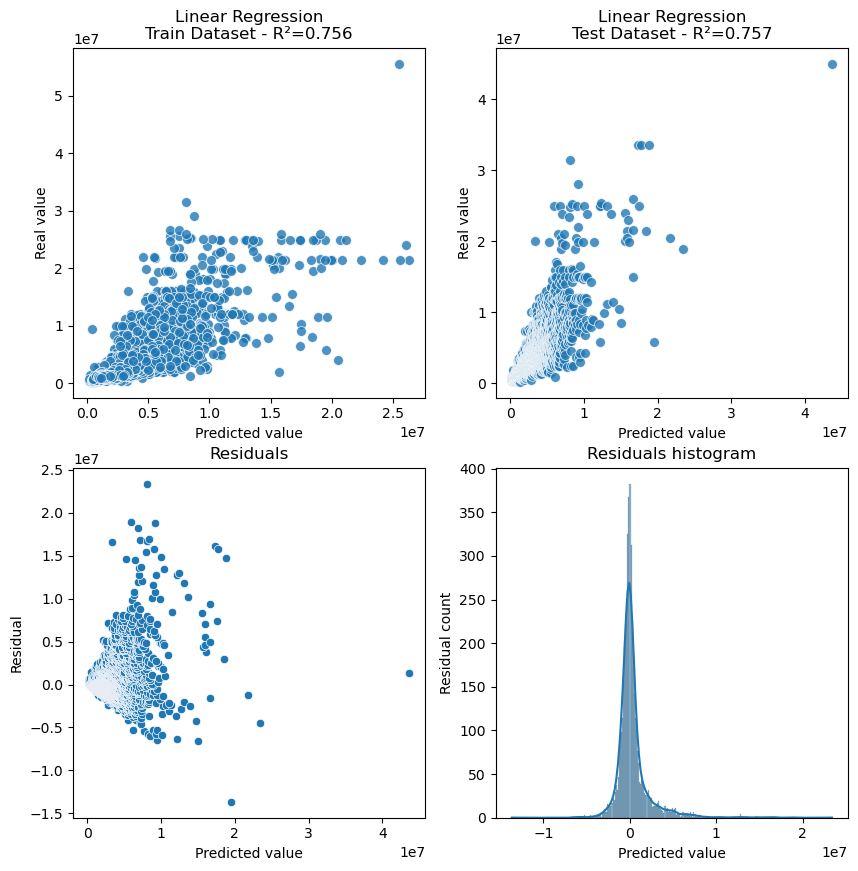

In [168]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Class to hold the best linear model
class class_best_regressor:
	score = 0
	model = None

	def check_regressor(self, regressor):
		new_score = regressor.score(X_test, y_test)
		if(new_score > self.score):
			self.score = new_score
			self.model = regressor

best_regressor = class_best_regressor()

# Simple linear regression
linreg = LinearRegression().fit(X_train, y_train)

best_regressor.check_regressor(linreg)

# Lasso model

for alpha in [0.00001, 0.001, 0.005, 0.05, 0.5, 1]:
	linlasso = Lasso(alpha=alpha, max_iter = 100_000).fit(X_train, y_train)
	best_regressor.check_regressor(linlasso)

# Ridge Model

for alpha in [0.00001, 0.001, 0.005, 0.05, 0.5, 1]:
	linridge = Ridge(alpha=alpha, max_iter = 10000).fit(X_train, y_train)
	best_regressor.check_regressor(linridge)

# Print best linear model

print(f'Best regressor: {best_regressor.model}')

# Plot best model

fig, axs =  plt.subplots(2,2, figsize=(10,10))
axs = iter(axs.reshape(1, -1)[0])

# Plotting of the train dataset
ax = next(axs)
y_hat_train = pd.Series(best_regressor.model.predict(X_train), index=y_train.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat_train), y=np.expm1(y_train), marker= 'o', s=50, alpha=0.8, ax=ax)
ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Linear Regression\nTrain Dataset - R²={best_regressor.model.score(X_train, y_train):.3f}'
)

# Plotting of the test dataset
ax = next(axs)
y_hat = pd.Series(best_regressor.model.predict(X_test), index=X_test.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_test.loc[y_hat.index]), marker= 'o', s=50, alpha=0.8, ax=ax)
ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Linear Regression\nTest Dataset - R²={best_regressor.model.score(X_test, y_test):.3f}'
)

# Plotting of residuals Scatterplot

ax = next(axs)
sorted_y_test = y_test.sort_values()
sorted_x_test = X_test.reindex(sorted_y_test.index)
predicted_values = np.expm1(best_regressor.model.predict(sorted_x_test))
residuals = (np.expm1(sorted_y_test) - predicted_values)
sns.scatterplot(x=predicted_values, y=residuals, ax=ax)
ax.set(ylabel='Residual',
       xlabel='Predicted value',
	   title=f'Residuals'
);

# Plotting of residuals Histogram

ax = next(axs)
sns.histplot(data=residuals, ax=ax, kde=True)
ax.set(ylabel='Residual count',
       xlabel='Predicted value',
	   title=f'Residuals histogram'
);

# Random Forest Regressor

In [85]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()

forest.fit(X_train, y_train);

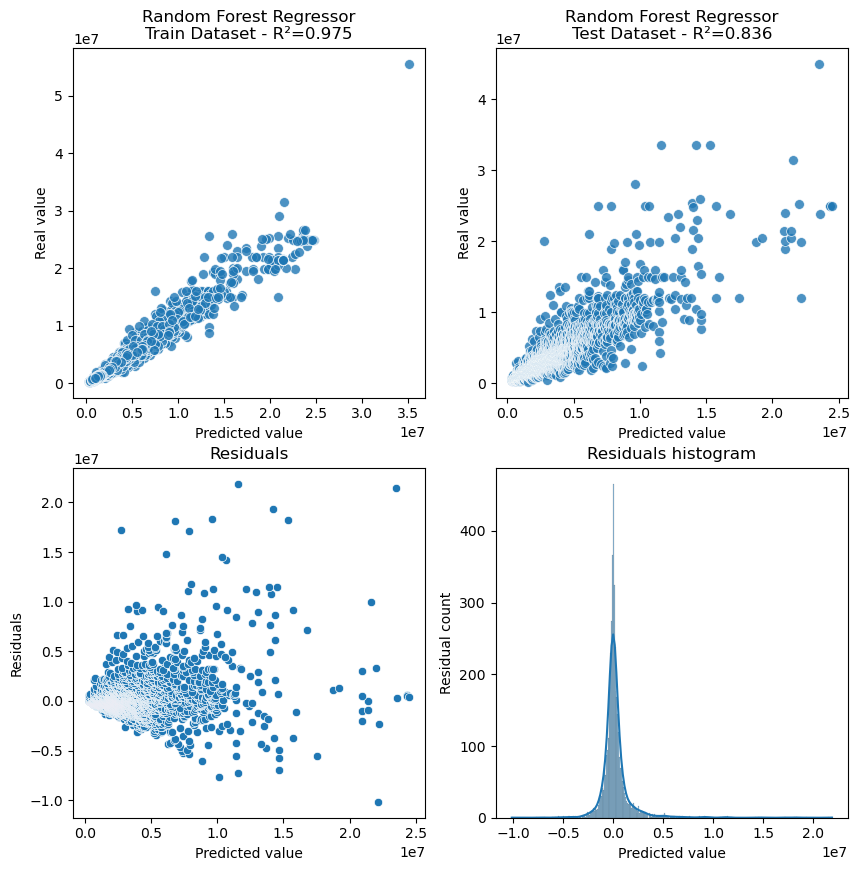

In [169]:
# Plot forest model

fig, axs =  plt.subplots(2,2, figsize=(10,10))
axs = iter(axs.reshape(1, -1)[0])

# Plotting of the train dataset
ax = next(axs)
y_hat_train = pd.Series(forest.predict(X_train), index=y_train.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat_train), y=np.expm1(y_train), marker= 'o', s=50, alpha=0.8, ax=ax)
ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Random Forest Regressor\nTrain Dataset - R²={forest.score(X_train, y_train):.3f}'
)

# Plotting of the test dataset
ax = next(axs)
y_hat = pd.Series(forest.predict(X_test), index=X_test.index).sort_values()
sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_test.loc[y_hat.index]), marker= 'o', s=50, alpha=0.8, ax=ax)
ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Random Forest Regressor\nTest Dataset - R²={forest.score(X_test, y_test):.3f}'
)

# Plotting of residuals

ax = next(axs)
sorted_y_test = y_test.sort_values()
sorted_x_test = X_test.reindex(sorted_y_test.index)
predicted_values = np.expm1(forest.predict(sorted_x_test))
residuals = (np.expm1(sorted_y_test) - predicted_values)
sns.scatterplot(x=predicted_values, y=residuals, ax=ax)
ax.set(ylabel='Residuals',
       xlabel='Predicted value',
	   title=f'Residuals'
);

# Plotting of residuals Histogram

ax = next(axs)
sns.histplot(data=residuals, ax=ax, kde=True)
ax.set(ylabel='Residual count',
       xlabel='Predicted value',
	   title=f'Residuals histogram'
);

In [186]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators':[5,50,300],
    'max_depth':[2,10,None],
    'min_samples_split':[2,8],
    'max_features':['sqrt', 'log2', None],
    'n_jobs':[-1]
}

grid_search = GridSearchCV(forest,
                           param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train);

print(f'Best estimator parameters: {grid_search.best_estimator_}')
print(f'Best estimator score: {grid_search.best_estimator_.score(X_test, y_test)}')

Best estimator parameters: RandomForestRegressor(max_features=None, min_samples_split=8, n_estimators=300,
                      n_jobs=-1)
Best estimator score: 0.8386369107400121


In [185]:
param_grid = { 
    'n_estimators':[300, 600],
    'max_depth':[None],
    'min_samples_split':[8, 16, 24],
    'max_features':[None],
    'n_jobs':[-1]
}

grid_search = GridSearchCV(forest,
                           param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train);

print(f'Best estimator parameters: {grid_search.best_estimator_}')
print(f'Best estimator score: {grid_search.best_estimator_.score(X_test, y_test)}')

Best estimator parameters: RandomForestRegressor(max_features=None, min_samples_split=8, n_estimators=600,
                      n_jobs=-1)
Best estimator score: 0.8385327192235842
